This notebook performs decoding experiments that predict, on a moment by moment basis,
the lick direction of the animal, based on the neural activity. 

Key structs:
* `data_opts` - Set options about how the neural data and labeling data is structured. 

* `neuron_opts` - For a given classification run, defines which neurons are included. An experiment group is defined by a sequence of `neuron_opts` structs. 

* `train_opts` - Parameters of the training algorithm (i.e. neural net size etc.)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# %pdb

import os
import sys
os.environ['MKL_THREADING_LAYER'] = 'GNU'

from matplotlib import pyplot as plt
import numpy as np
import scipy.stats

# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
import sklearn.feature_selection as feature_selection
from scipy.ndimage.filters import gaussian_filter1d

import pickle 
import keras
import time
import copy

from cosmos.traces.decoding_utils import *
from cosmos.traces.decoding.metrics import get_R2, get_rho
from cosmos.traces.decoding.decoders import DenseNNDecoder, LSTMDecoder
from cosmos.traces.decoding.decoders import GRUDecoder, SVRDecoder, XGBoostDecoder, SimpleRNNDecoder

import cosmos.traces.trace_analysis_utils as utils
from cosmos.behavior.bpod_dataset import BpodDataset
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces
import cosmos.params.trace_analyze_params as params


Using TensorFlow backend.


In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
# Select dataset.
data_dir = '/home/izkula/Dropbox/cosmos_data/'
fig_save_dir = '/home/izkula/Dropbox/cosmos/trace_analysis/'
bpod_dir = '/home/izkula/Dropbox/cosmos_data/behavior/'

dataset_id = 7 #7 #18 #19 #11 ### SET DATASET HERE.
dataset = params.DATASETS[dataset_id]
print(dataset)
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = fig_save_dir
dataset['behavior_dir'] = bpod_dir

### Set up save paths.
decoding_save_dir = os.path.join(data_dir, 'decoding_results', str(dataset_id))
os.makedirs(decoding_save_dir, exist_ok=True)
    
plot_dir = os.path.join(decoding_save_dir, 'plots')
os.makedirs(plot_dir, exist_ok=True)

{'info': '***Imported this 4/2/18. Very good behavior. 1240 sources.', 'date': '20180401', 'regressors_name': 'cux2m72-20180401-134904', 'bpod_file': 'cux2m72/COSMOSTrainMultiBlockGNG/Session Data/cux2m72_COSMOSTrainMultiBlockGNG_20180401_134852.mat', 'name': 'cux2ai148m72_COSMOSTrainMultiBlockGNG_1'}


(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:211
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_pre-reward.pdf
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_post-reward.pdf
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/izkula/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/success_rate.pdf
LED trials: 212
Processing traces.
[-34.99899927 423.99899927]
[297.73913811 301.26086189]


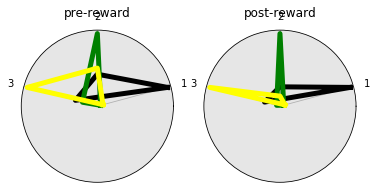

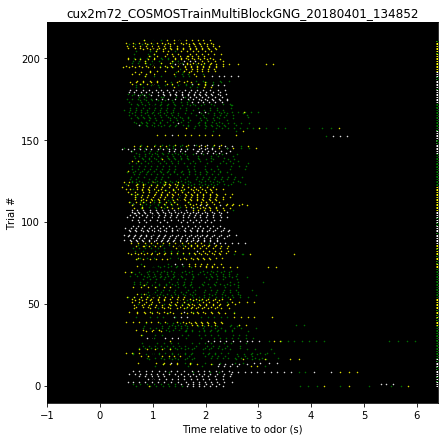

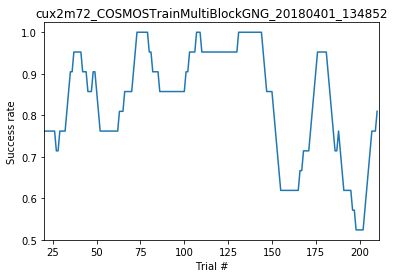

In [4]:
# Load data
CT = CosmosTraces(dataset)
BD = CT.bd

# Prepare train and test data

In [5]:
CT.Ct.shape


(1240, 205, 211)

In [6]:
np.max(CT.S)

250.92083997357747

In [7]:
%pdb

Automatic pdb calling has been turned OFF


{'train_frac': 0.5, 'valid_frac': 0.25, 'bins_before': 0, 'remove_multi_licks': False, 'decoding_set': 1, 'center_Y': True, 'bins_current': 1, 'rand_seed': 0, 'standardize_X': True, 'train_feat': 'spikes', 'test_frac': 0.25, 'bins_after': 0}
Data split into train, test, validate sets. 
Fractions: Train 0.493, Test 0.245 Valid 0.253
Z-scoring X!!
Max X 69.555675567883
X_train: (30191, 1, 1240) X_test: (15012, 1, 1240)
# experiments: 6
Expt range: 3075 to 3080
Expt 3075, setting rand, nneurons 50
EVR: 0.9999999999999999
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003075


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


62.33771514892578
Expt 3076, setting rand, nneurons 100
EVR: 0.5396743114798125
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003076


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


54.517993450164795
Expt 3077, setting rand, nneurons 250
EVR: 0.24527032706613436
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003077


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


54.07199811935425
Expt 3078, setting rand, nneurons 500
EVR: 0.143036660425815
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003078


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


55.18040156364441
Expt 3079, setting rand, nneurons 750
EVR: 0.11106190982218878
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003079


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


59.69041156768799
Expt 3080, setting rand, nneurons 1000
EVR: 0.09247952318079093
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003080


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


65.29690337181091
Total time: 351.14805
Data split into train, test, validate sets. 
Fractions: Train 0.502, Test 0.242 Valid 0.245
Z-scoring X!!
Max X 54.8126551625709
X_train: (30773, 1, 1240) X_test: (14805, 1, 1240)
# experiments: 6
Expt range: 3081 to 3086
Expt 3081, setting rand, nneurons 50
EVR: 1.0
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003081


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


60.41053819656372
Expt 3082, setting rand, nneurons 100
EVR: 0.5387309446139704
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003082


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


60.699881076812744
Expt 3083, setting rand, nneurons 250
EVR: 0.24370141008339535
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003083


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


60.22436237335205
Expt 3084, setting rand, nneurons 500
EVR: 0.14125383551972392
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003084


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


61.107537508010864
Expt 3085, setting rand, nneurons 750
EVR: 0.11129751140903123
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003085


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


62.01856565475464
Expt 3086, setting rand, nneurons 1000
EVR: 0.09220403744151173
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003086


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


64.22453260421753
Total time: 368.71787
Data split into train, test, validate sets. 
Fractions: Train 0.502, Test 0.247 Valid 0.241
Z-scoring X!!
Max X 59.43387495908256
X_train: (30763, 1, 1240) X_test: (15143, 1, 1240)
# experiments: 6
Expt range: 3087 to 3092
Expt 3087, setting rand, nneurons 50
EVR: 0.9999999999999999
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003087


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


59.55957341194153
Expt 3088, setting rand, nneurons 100
EVR: 0.5367067251141667
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003088


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


59.01491904258728
Expt 3089, setting rand, nneurons 250
EVR: 0.24183364068190488
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003089


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


59.65821123123169
Expt 3090, setting rand, nneurons 500
EVR: 0.14052974077617558
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003090


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


61.59314322471619
Expt 3091, setting rand, nneurons 750
EVR: 0.10940177668594557
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003091


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


68.20161271095276
Expt 3092, setting rand, nneurons 1000
EVR: 0.09101513581467277
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003092


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


69.72665357589722
Total time: 377.78568
Data split into train, test, validate sets. 
Fractions: Train 0.492, Test 0.253 Valid 0.245
Z-scoring X!!
Max X 74.05257730360735
X_train: (30155, 1, 1240) X_test: (15480, 1, 1240)
# experiments: 6
Expt range: 3093 to 3098
Expt 3093, setting rand, nneurons 50
EVR: 0.9999999999999998
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003093


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


63.271442890167236
Expt 3094, setting rand, nneurons 100
EVR: 0.5379059129857645
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003094


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


64.69136166572571
Expt 3095, setting rand, nneurons 250
EVR: 0.24427773283778462
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003095


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


66.59134125709534
Expt 3096, setting rand, nneurons 500
EVR: 0.14166926320545828
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003096


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


73.61493492126465
Expt 3097, setting rand, nneurons 750
EVR: 0.11088420562631435
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003097


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


73.6910514831543
Expt 3098, setting rand, nneurons 1000
EVR: 0.09162372831734678
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003098


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


80.05772280693054
Total time: 421.95217
Overall time in seconds:
1559.9540703296661


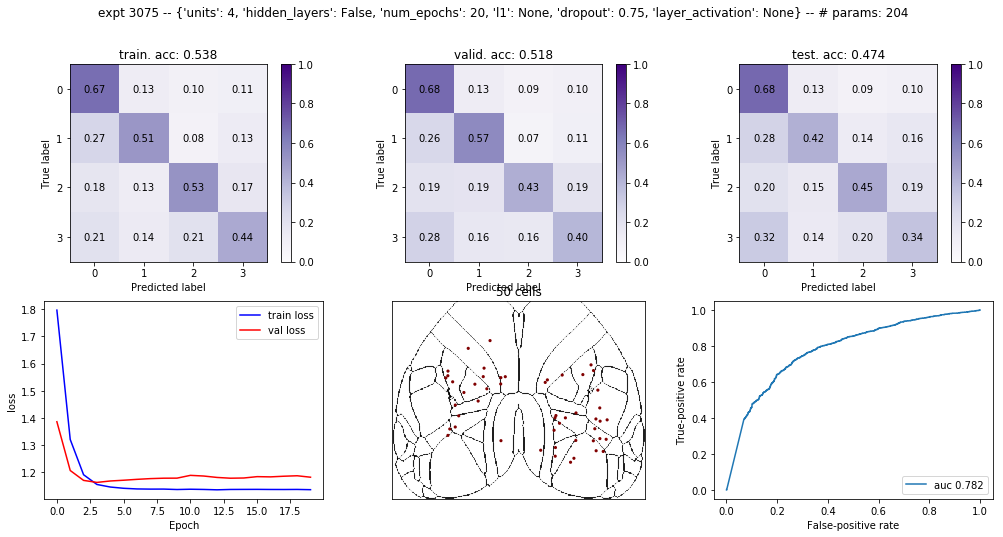

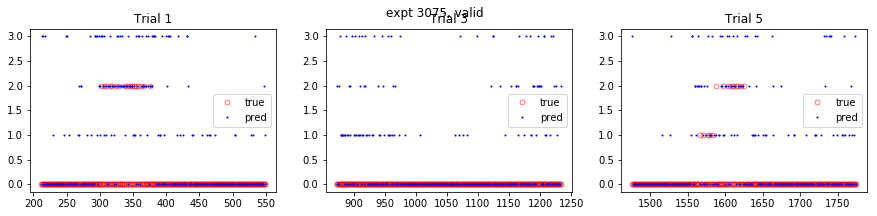

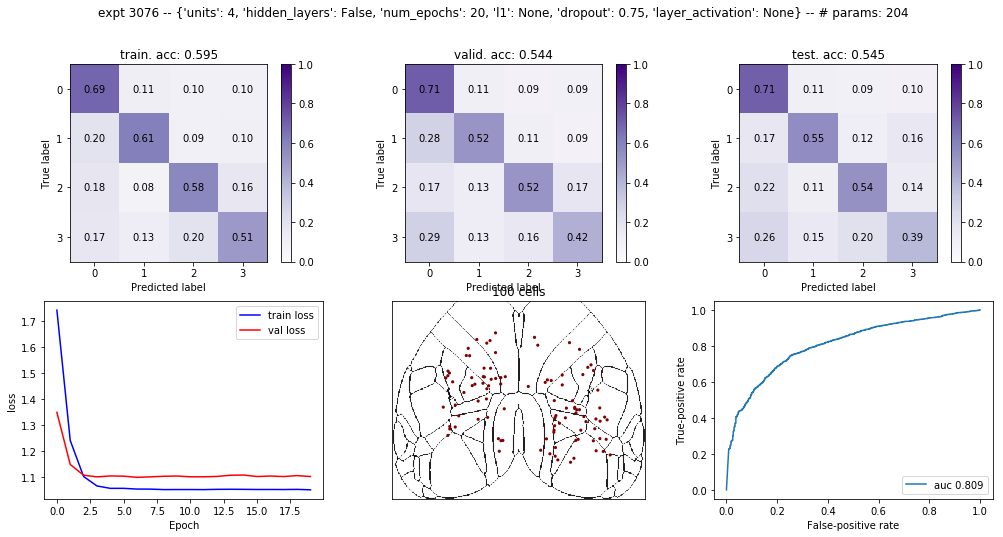

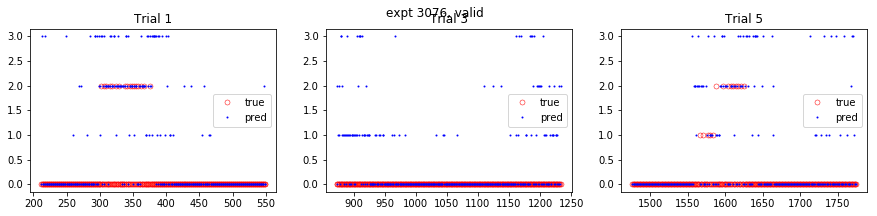

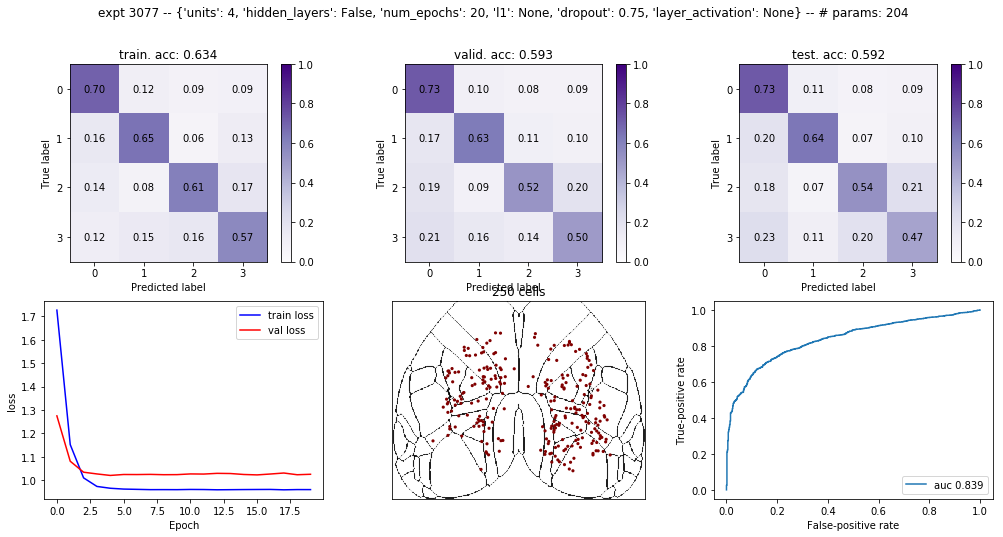

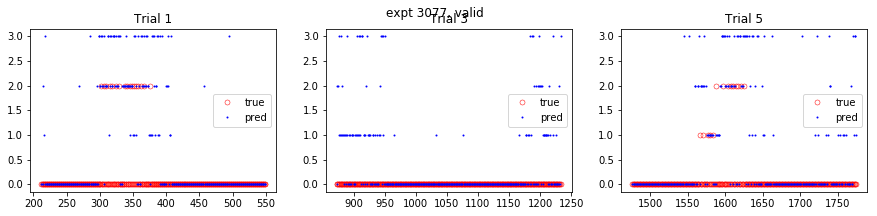

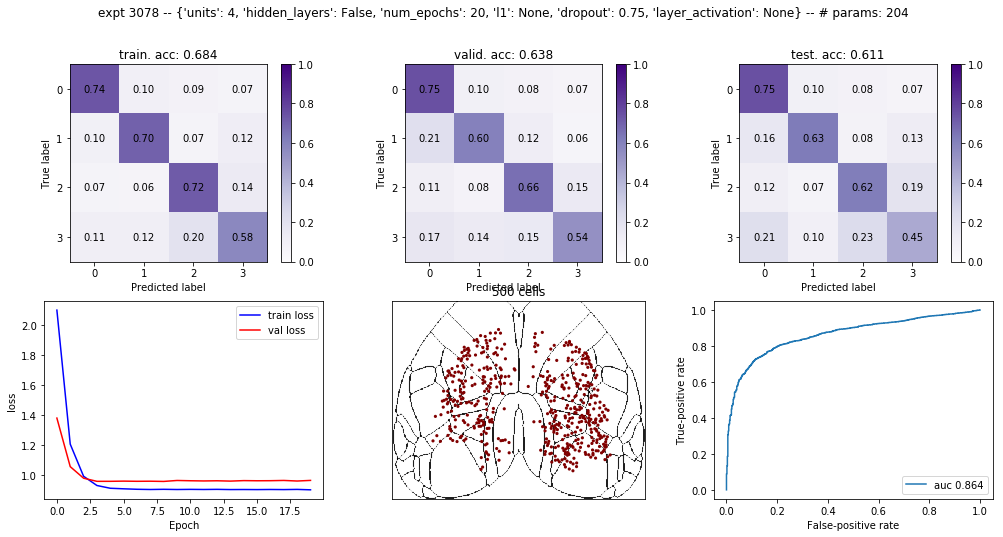

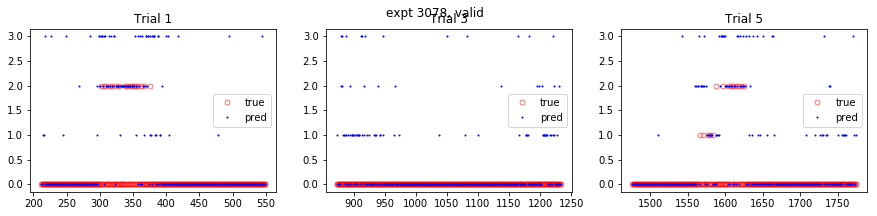

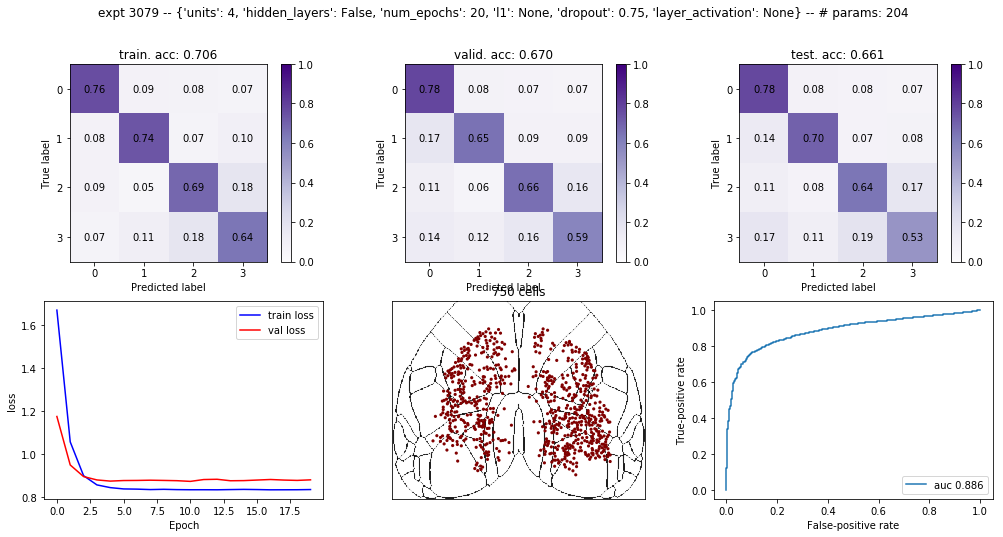

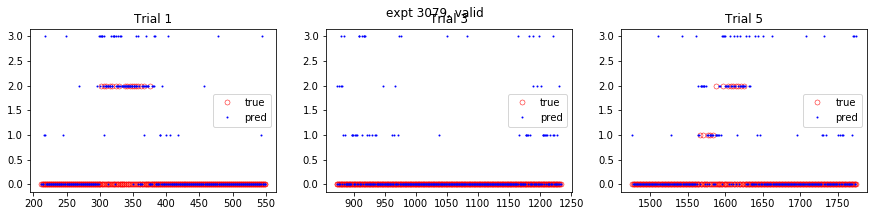

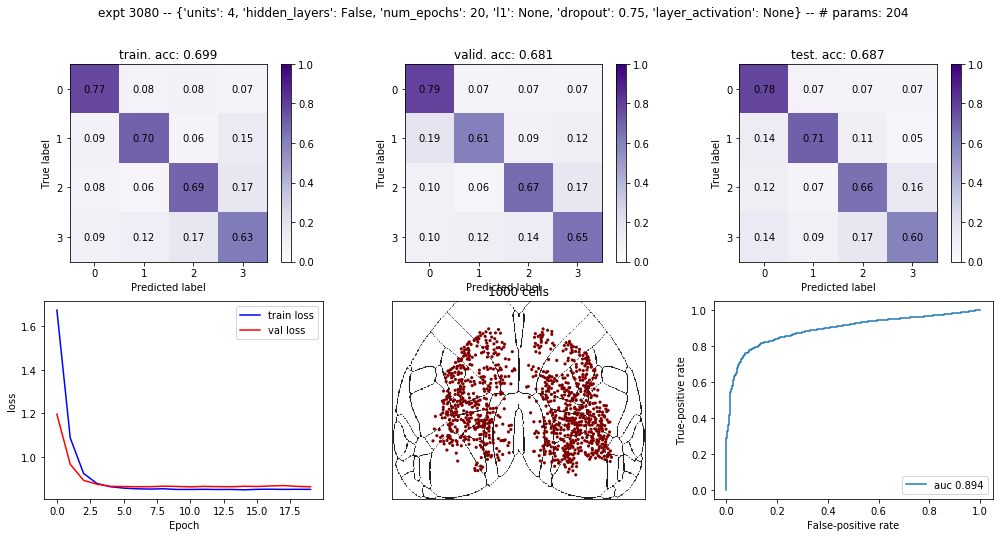

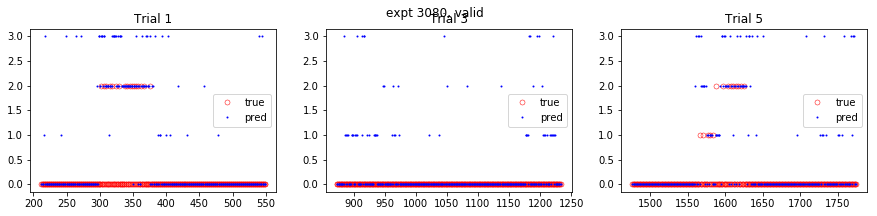

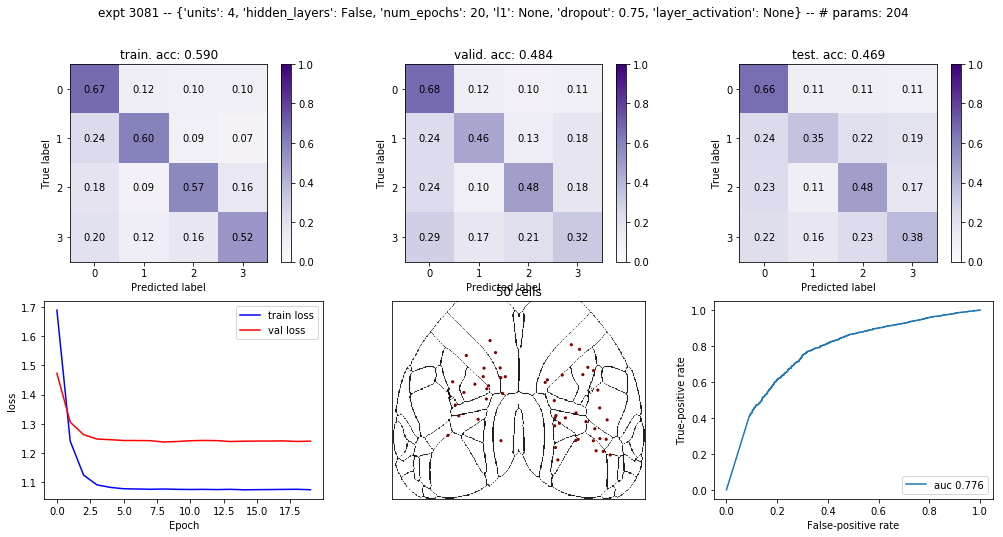

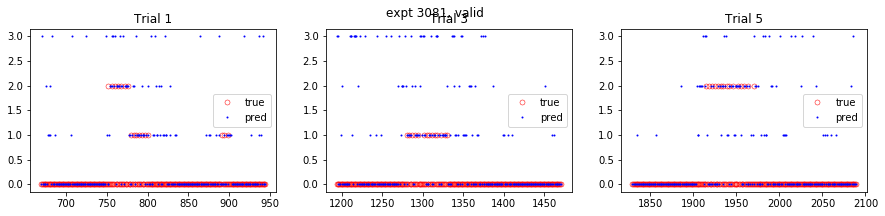

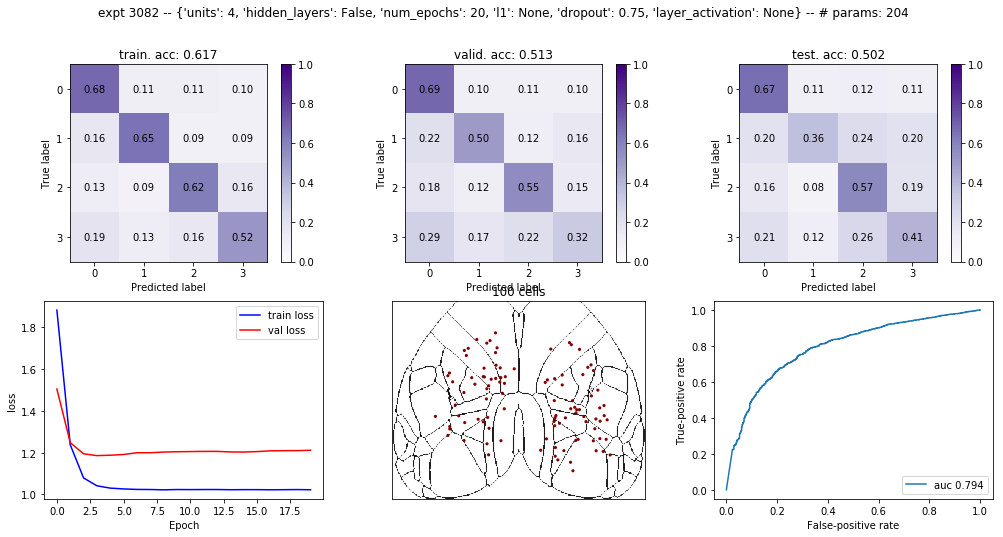

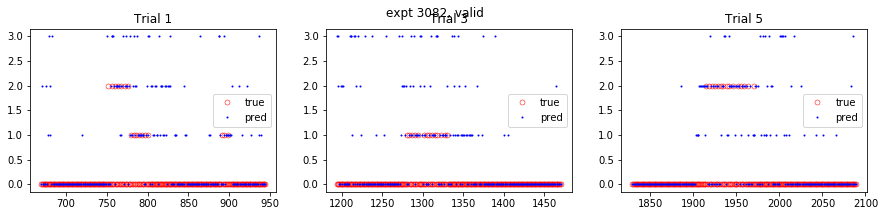

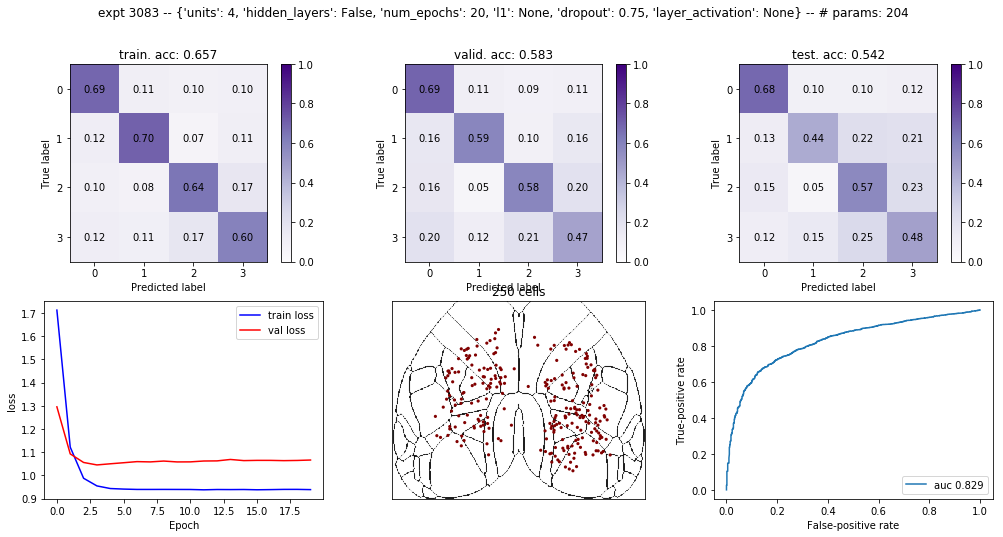

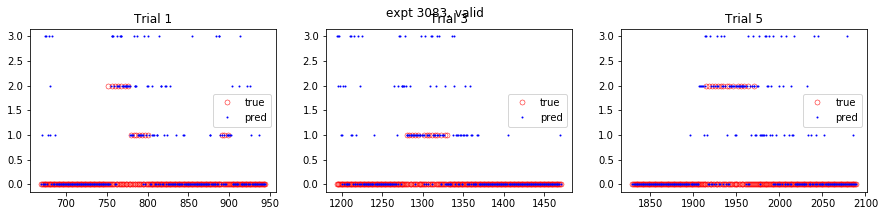

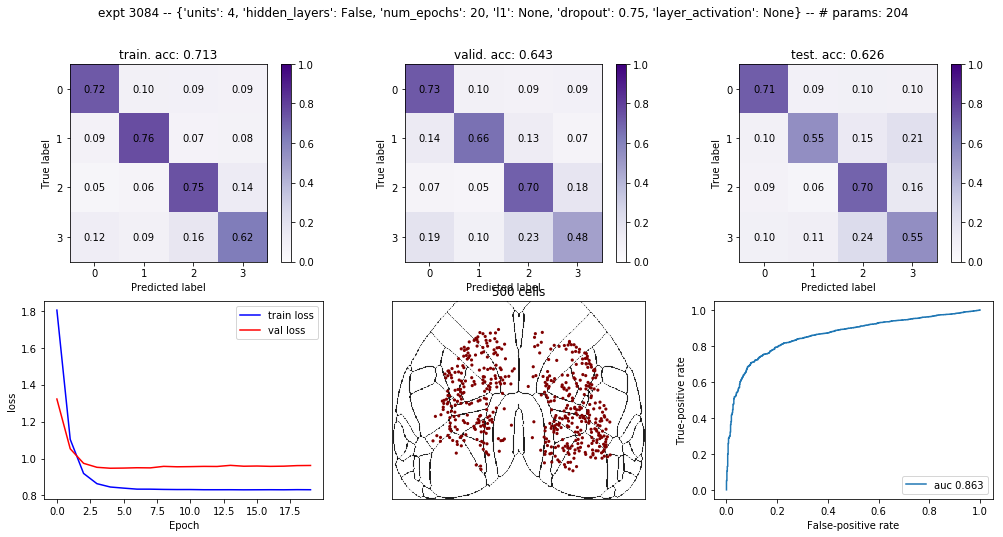

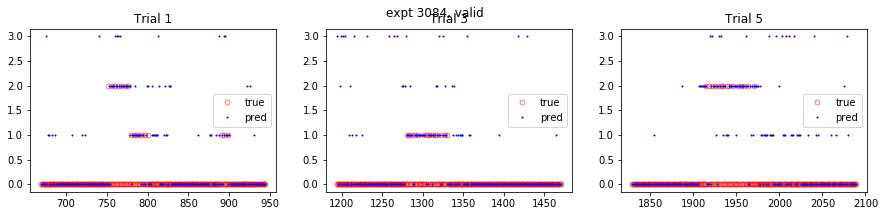

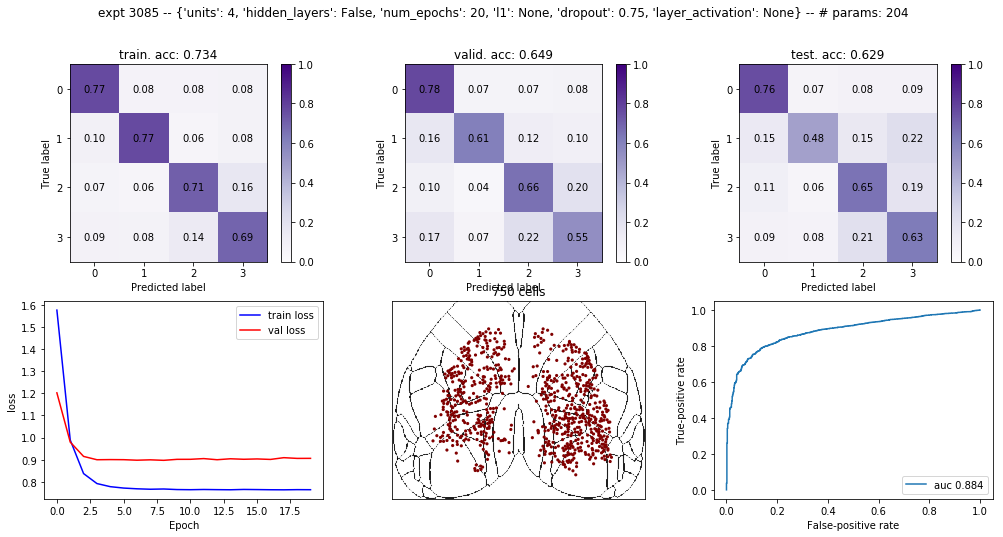

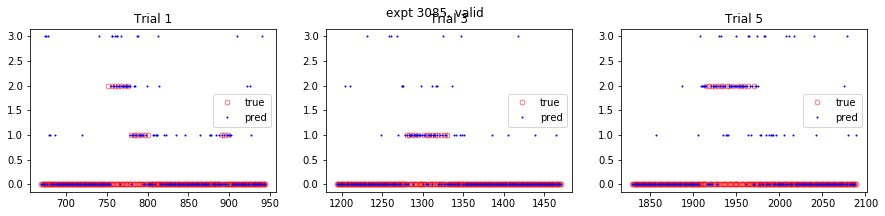

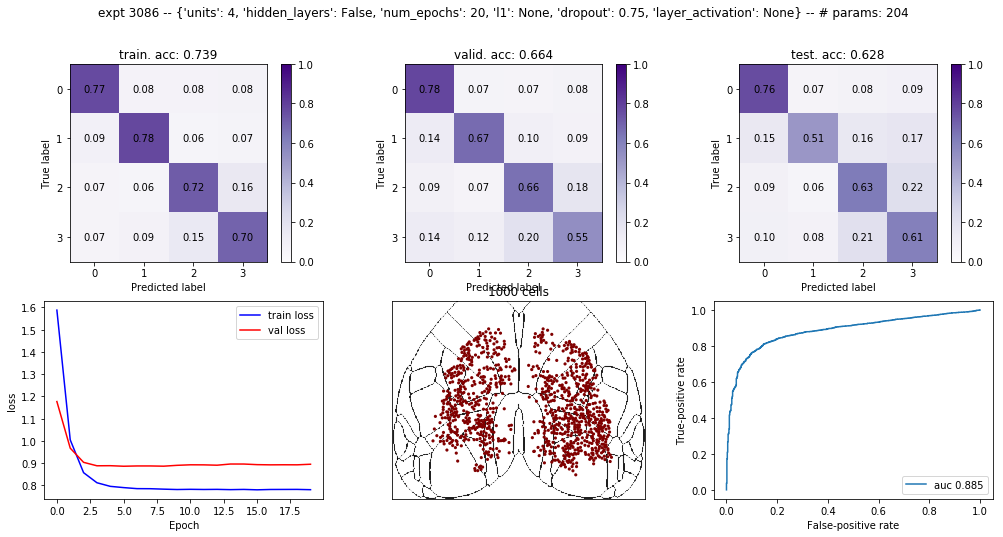

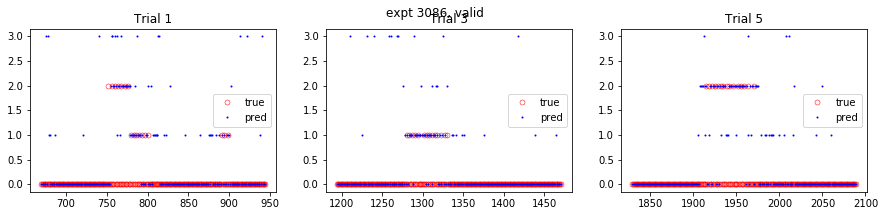

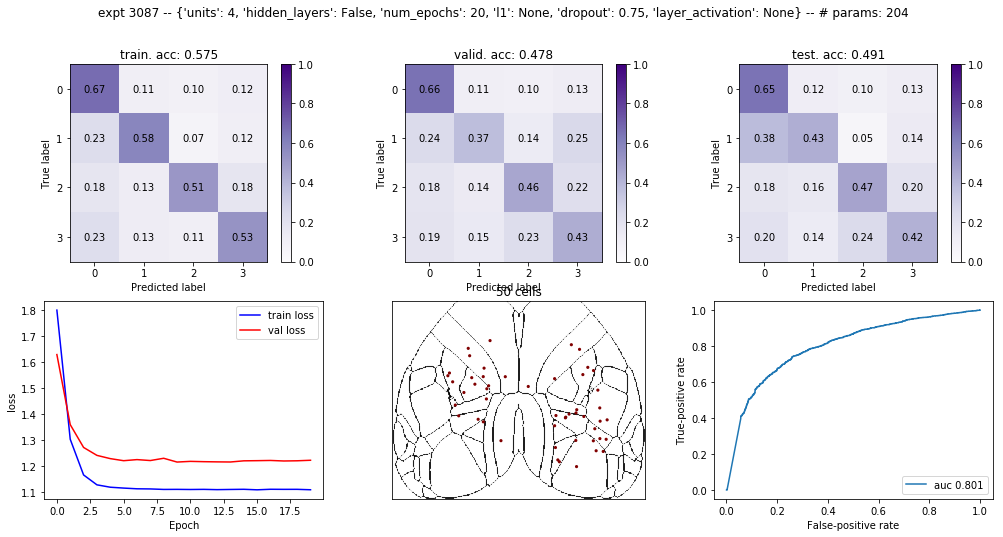

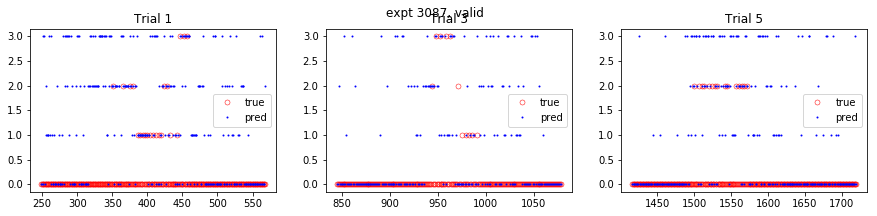

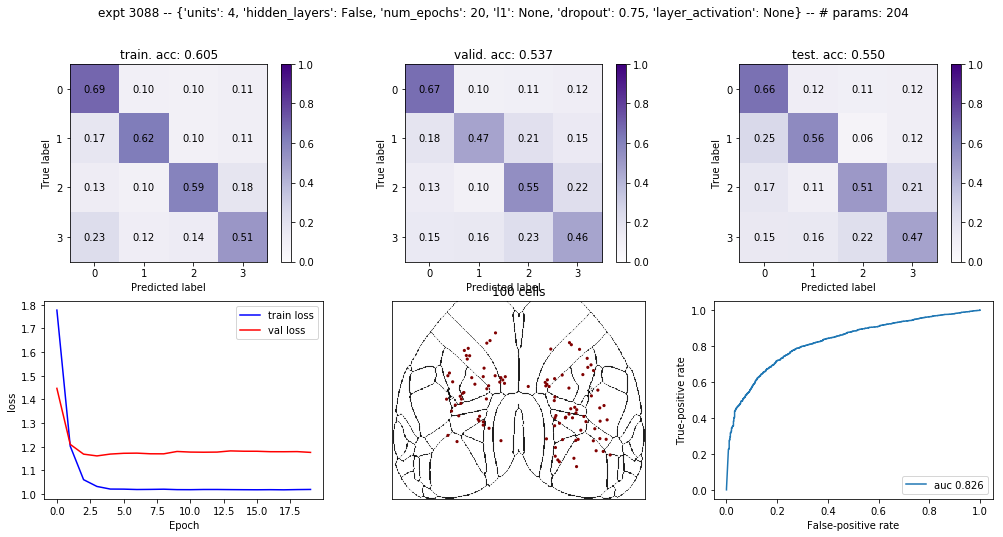

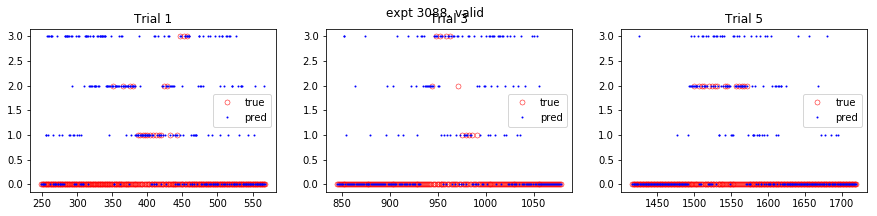

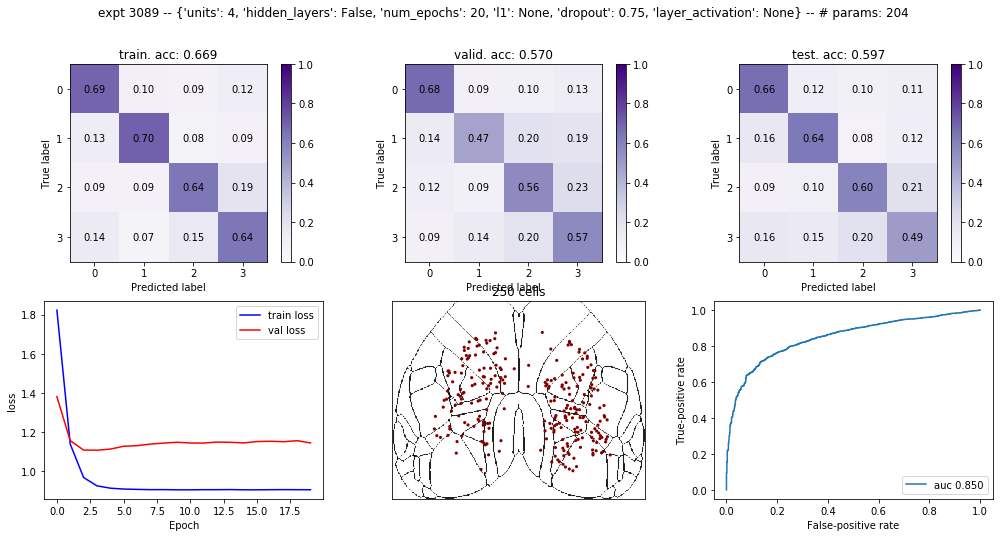

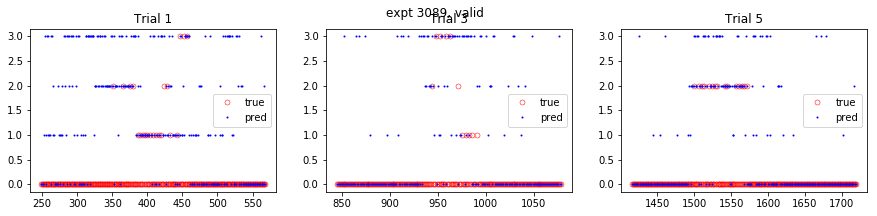

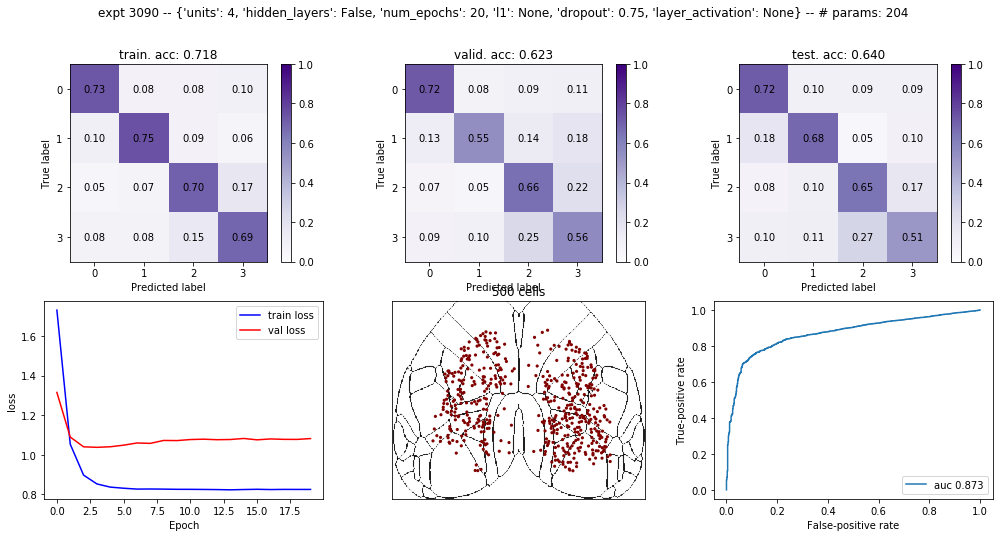

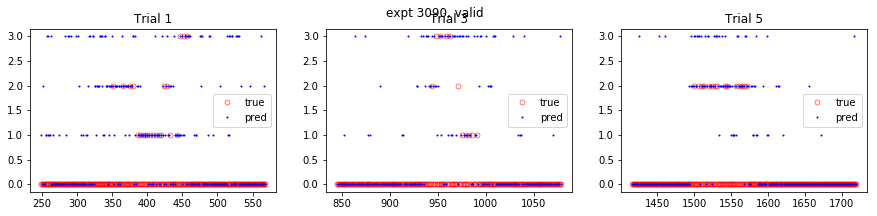

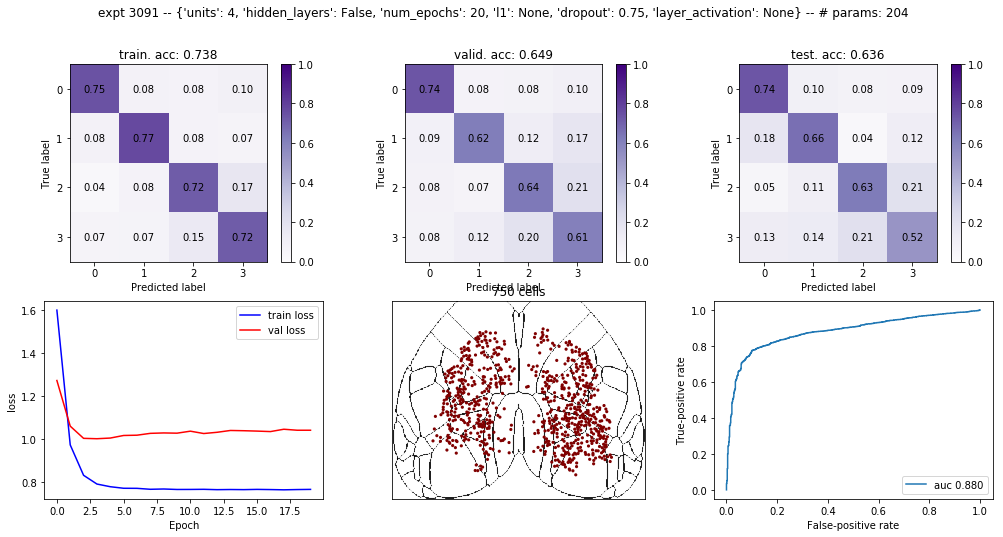

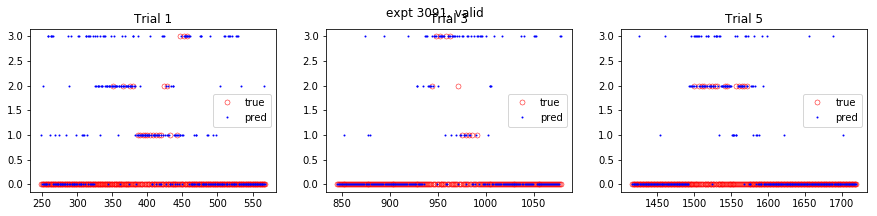

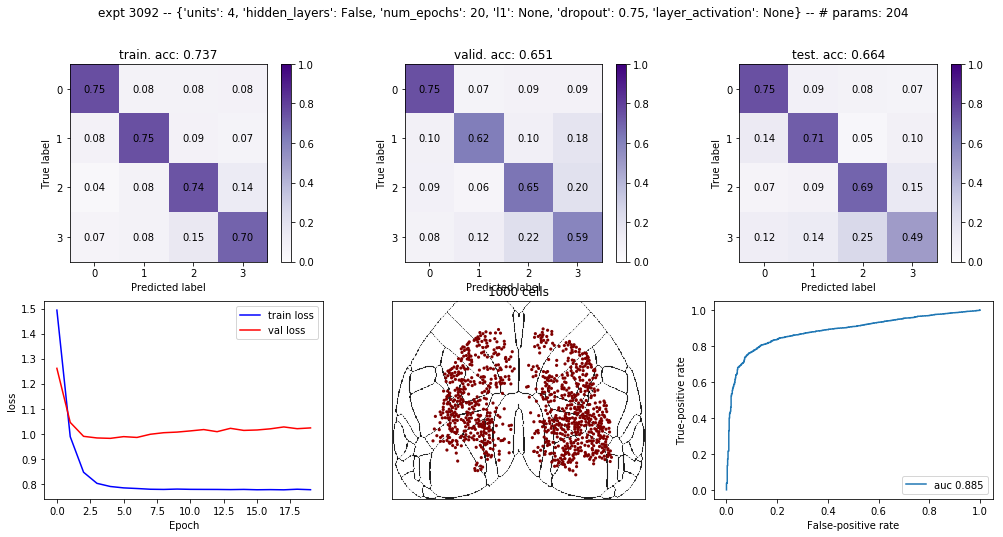

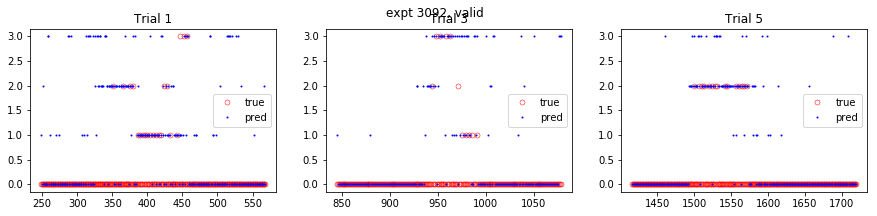

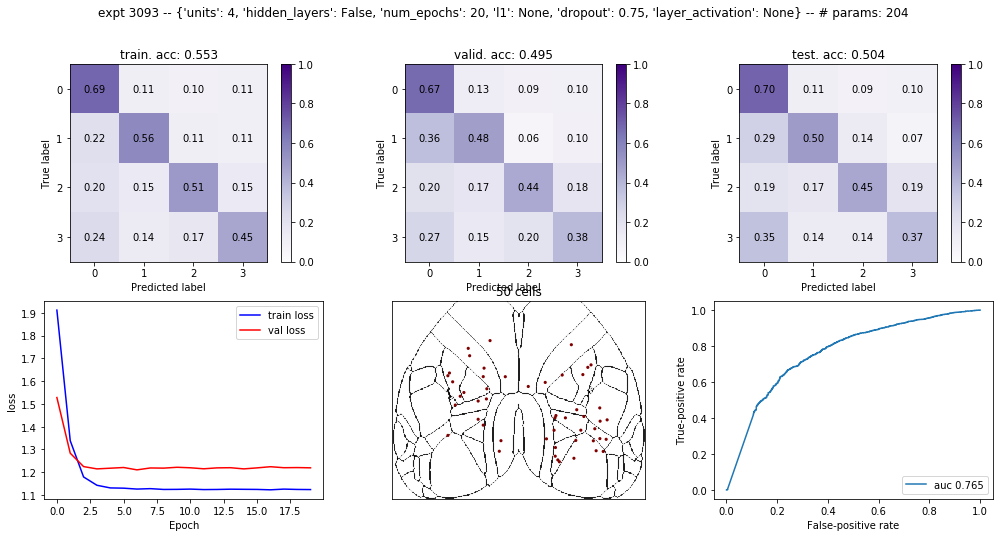

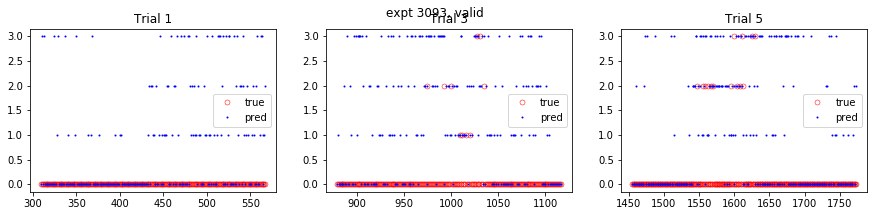

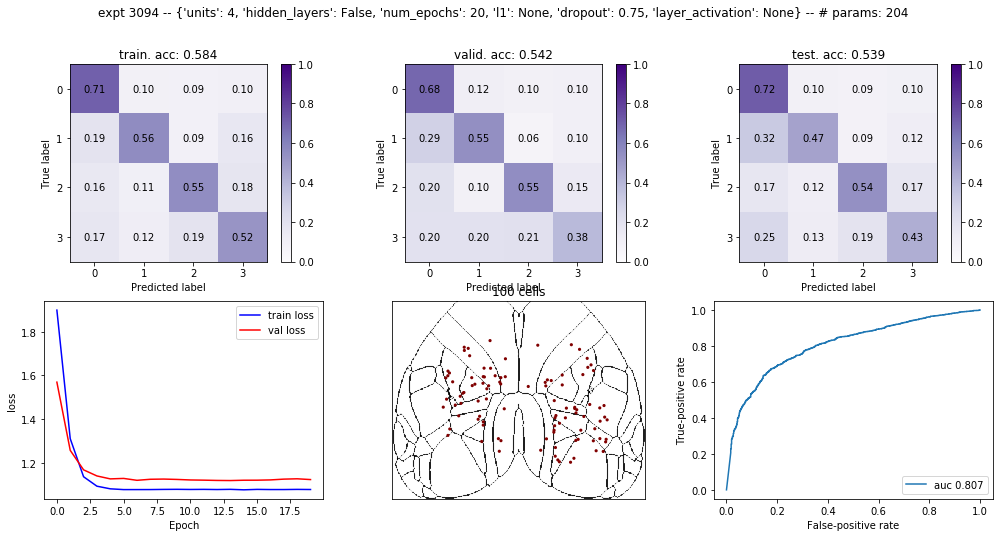

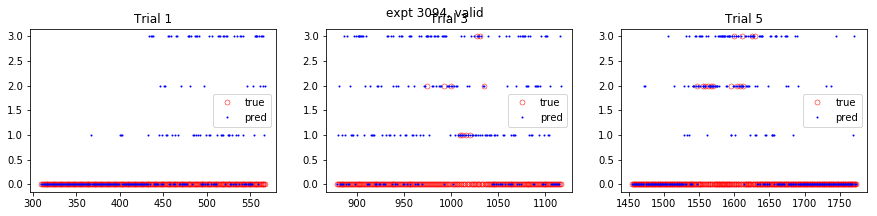

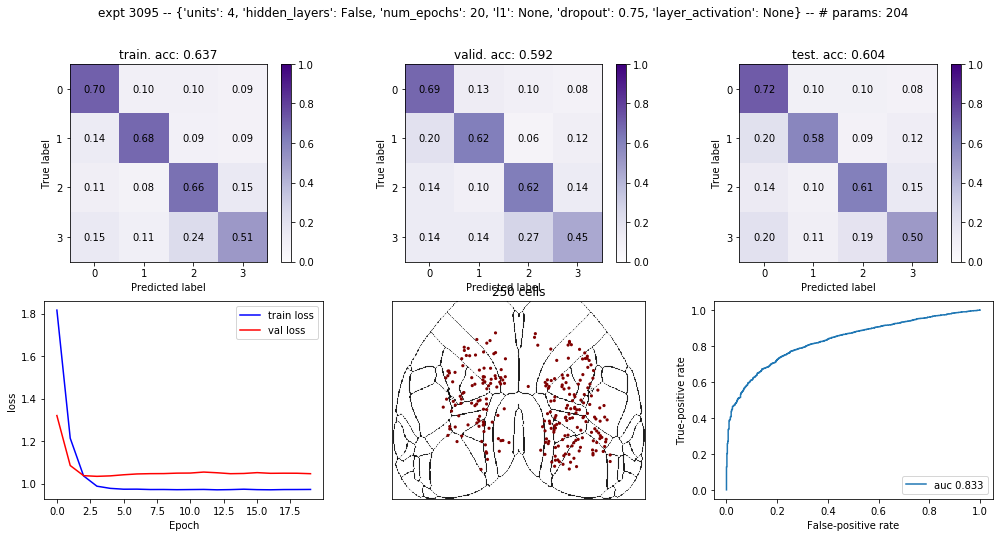

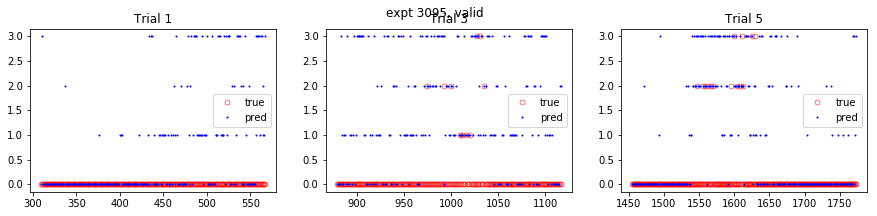

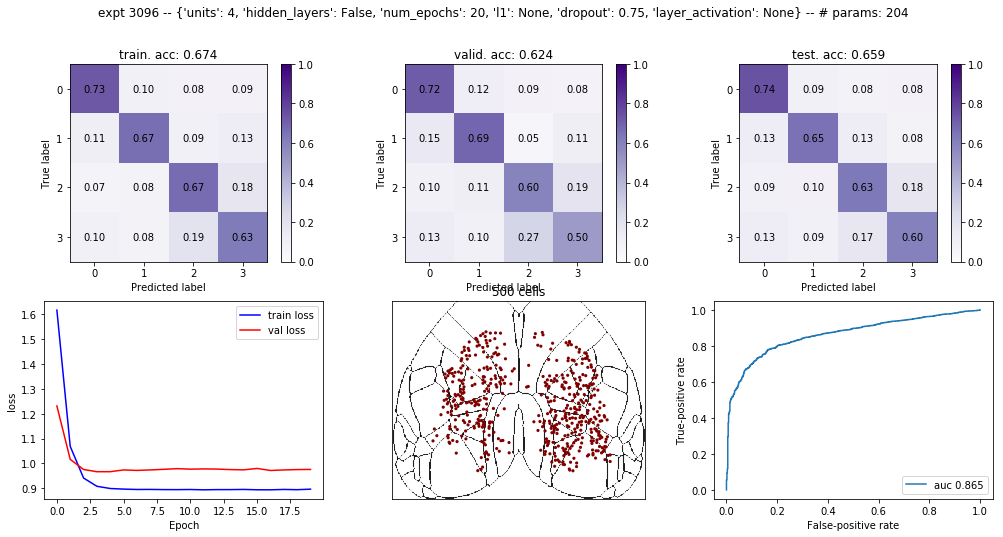

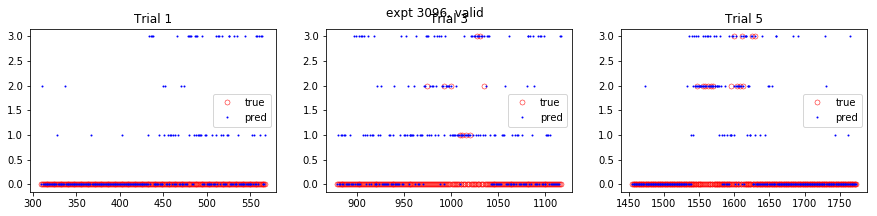

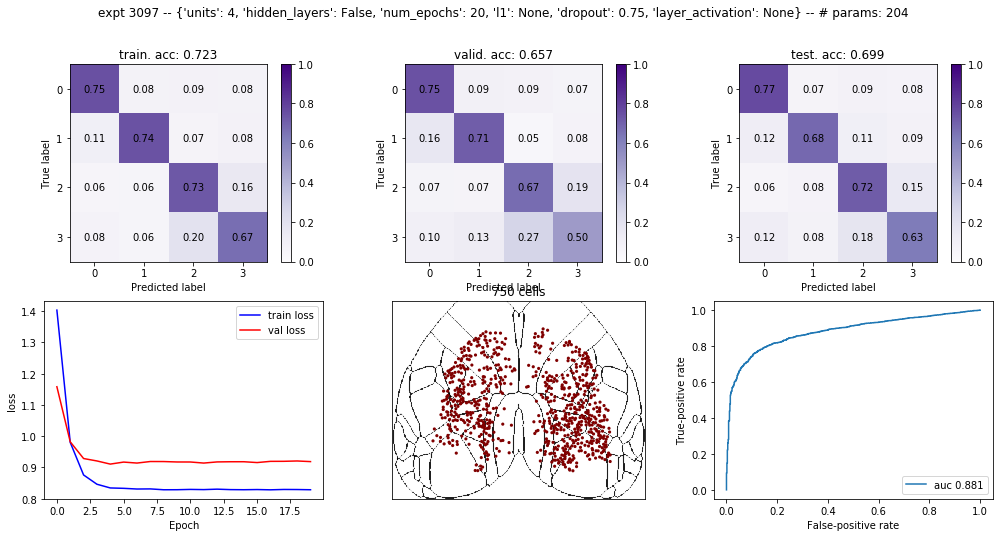

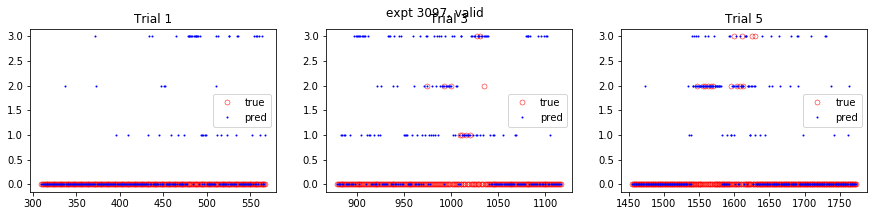

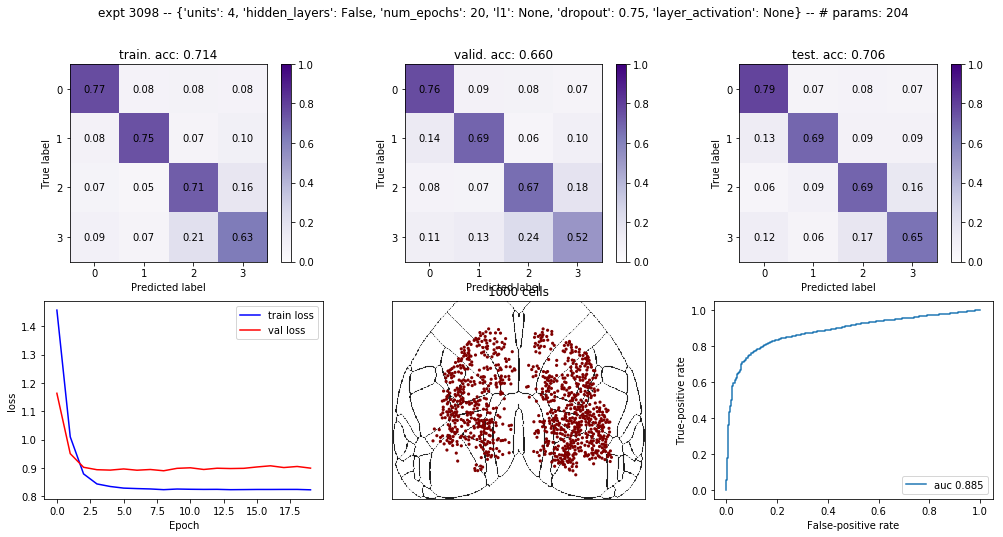

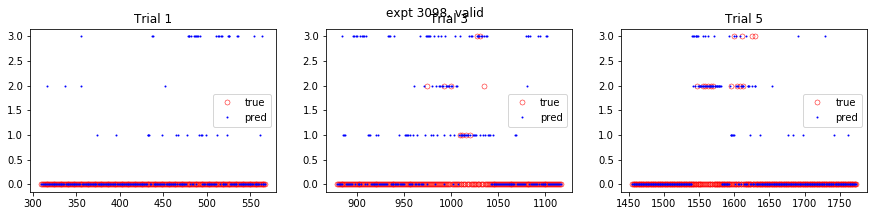

In [8]:
from cosmos.traces.lick_decoder import LickDecoder

### See du.select_experiment_group for information on the different expt_group_id's.
### Key groups: 8, 9, 4, 10

all_expts_str = []
T0 = time.time()

for expt_group_id in [8, 9, 4, 10]: #[8, 9, 4]: #[8, 9, 4, 10]:
    LD = LickDecoder(dataset_id, CT, decoding_save_dir, just_decode_licks=False)

    expts_info, expts_str = LD.decode_licks(nfolds=4, #1, #4 
                                            expt_group_id=expt_group_id, ### Make '0' for do_single_experiment
                                            do_pca = True,
                                            n_pca_components = 75, #75 ## CHANGE THIS BACK IF > 75 neurons
                                            do_shuffle_data = False)
    all_expts_str.append(expts_str)
print('Overall time in seconds:')
print(time.time() - T0)

In [9]:
all_expts_str

["'id': 7, 'expt_nums': np.arange(3075, 3099),'expt_type': 'nneurons', 'info':8"]

{'train_frac': 0.5, 'valid_frac': 0.25, 'bins_before': 0, 'remove_multi_licks': False, 'decoding_set': 1, 'center_Y': True, 'bins_current': 1, 'rand_seed': 0, 'standardize_X': True, 'train_feat': 'spikes', 'test_frac': 0.25, 'bins_after': 0}
Data split into train, test, validate sets. 
Fractions: Train 0.493, Test 0.245 Valid 0.253
Z-scoring X!!
Max X 69.555675567883
X_train: (30191, 1, 1240) X_test: (15012, 1, 1240)
# experiments: 6
Expt range: 3099 to 3104
Expt 3099, setting rand, nneurons 50
Using circular permutation shuffle.
EVR: 0.9999999999999999
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003099


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


76.5481469631195
Expt 3100, setting rand, nneurons 100
Using circular permutation shuffle.
EVR: 0.5396743114798125
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003100


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


79.17666602134705
Expt 3101, setting rand, nneurons 250
Using circular permutation shuffle.
EVR: 0.24527032706613436
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003101


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


77.22931623458862
Expt 3102, setting rand, nneurons 500
Using circular permutation shuffle.
EVR: 0.143036660425815
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003102


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


82.09833645820618
Expt 3103, setting rand, nneurons 750
Using circular permutation shuffle.
EVR: 0.11106190982218878
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003103


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


85.49748277664185
Expt 3104, setting rand, nneurons 1000
Using circular permutation shuffle.
EVR: 0.09247952318079093
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003104


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


89.60579895973206
Total time: 490.18269
Data split into train, test, validate sets. 
Fractions: Train 0.502, Test 0.242 Valid 0.245
Z-scoring X!!
Max X 54.8126551625709
X_train: (30773, 1, 1240) X_test: (14805, 1, 1240)
# experiments: 6
Expt range: 3105 to 3110
Expt 3105, setting rand, nneurons 50
Using circular permutation shuffle.
EVR: 1.0
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003105


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


81.79832768440247
Expt 3106, setting rand, nneurons 100
Using circular permutation shuffle.
EVR: 0.5387309446139704
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003106


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


81.4014356136322
Expt 3107, setting rand, nneurons 250
Using circular permutation shuffle.
EVR: 0.24370141008339535
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003107


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


85.84911799430847
Expt 3108, setting rand, nneurons 500
Using circular permutation shuffle.
EVR: 0.14125383551972392
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003108


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


84.3102650642395
Expt 3109, setting rand, nneurons 750
Using circular permutation shuffle.
EVR: 0.11129751140903123
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003109


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


87.52241659164429
Expt 3110, setting rand, nneurons 1000
Using circular permutation shuffle.
EVR: 0.09220403744151173
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003110


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


89.64443945884705
Total time: 510.55844
Data split into train, test, validate sets. 
Fractions: Train 0.502, Test 0.247 Valid 0.241
Z-scoring X!!
Max X 59.43387495908256
X_train: (30763, 1, 1240) X_test: (15143, 1, 1240)
# experiments: 6
Expt range: 3111 to 3116
Expt 3111, setting rand, nneurons 50
Using circular permutation shuffle.
EVR: 0.9999999999999999
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003111


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


79.5257716178894
Expt 3112, setting rand, nneurons 100
Using circular permutation shuffle.
EVR: 0.5367067251141667
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003112


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


82.24541139602661
Expt 3113, setting rand, nneurons 250
Using circular permutation shuffle.
EVR: 0.24183364068190488
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003113


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


83.32271647453308
Expt 3114, setting rand, nneurons 500
Using circular permutation shuffle.
EVR: 0.14052974077617558
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003114


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


86.65042209625244
Expt 3115, setting rand, nneurons 750
Using circular permutation shuffle.
EVR: 0.10940177668594557
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003115


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


89.93733024597168
Expt 3116, setting rand, nneurons 1000
Using circular permutation shuffle.
EVR: 0.09101513581467277
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003116


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


93.2818193435669
Total time: 514.99434
Data split into train, test, validate sets. 
Fractions: Train 0.492, Test 0.253 Valid 0.245
Z-scoring X!!
Max X 74.05257730360735
X_train: (30155, 1, 1240) X_test: (15480, 1, 1240)
# experiments: 6
Expt range: 3117 to 3122
Expt 3117, setting rand, nneurons 50
Using circular permutation shuffle.
EVR: 0.9999999999999998
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003117


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


85.17163753509521
Expt 3118, setting rand, nneurons 100
Using circular permutation shuffle.
EVR: 0.5379059129857645
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003118


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


86.28079867362976
Expt 3119, setting rand, nneurons 250
Using circular permutation shuffle.
EVR: 0.24427773283778462
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003119


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


86.99880909919739
Expt 3120, setting rand, nneurons 500
Using circular permutation shuffle.
EVR: 0.14166926320545828
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003120


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


90.50218033790588
Expt 3121, setting rand, nneurons 750
Using circular permutation shuffle.
EVR: 0.11088420562631435
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003121


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


92.42553162574768
Expt 3122, setting rand, nneurons 1000
Using circular permutation shuffle.
EVR: 0.09162372831734678
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003122


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


89.99255347251892
Total time: 531.39908
Overall time in seconds:
2090.4249184131622


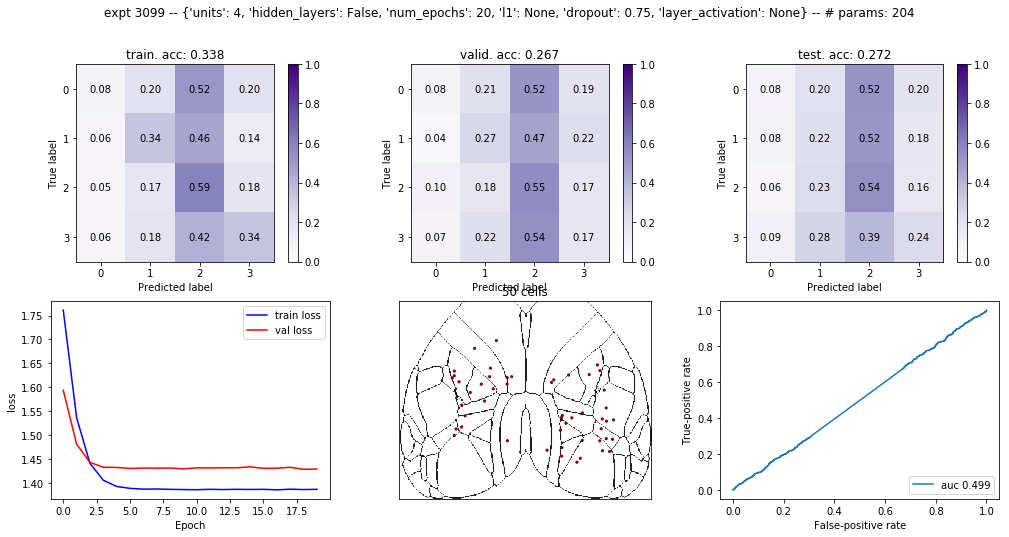

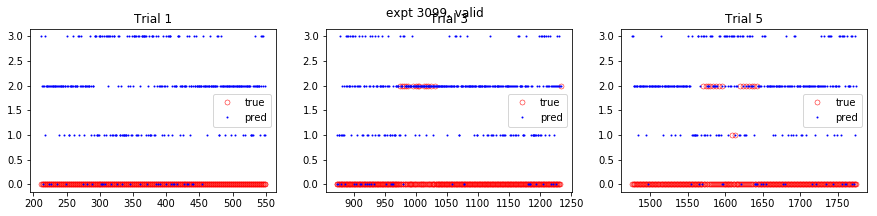

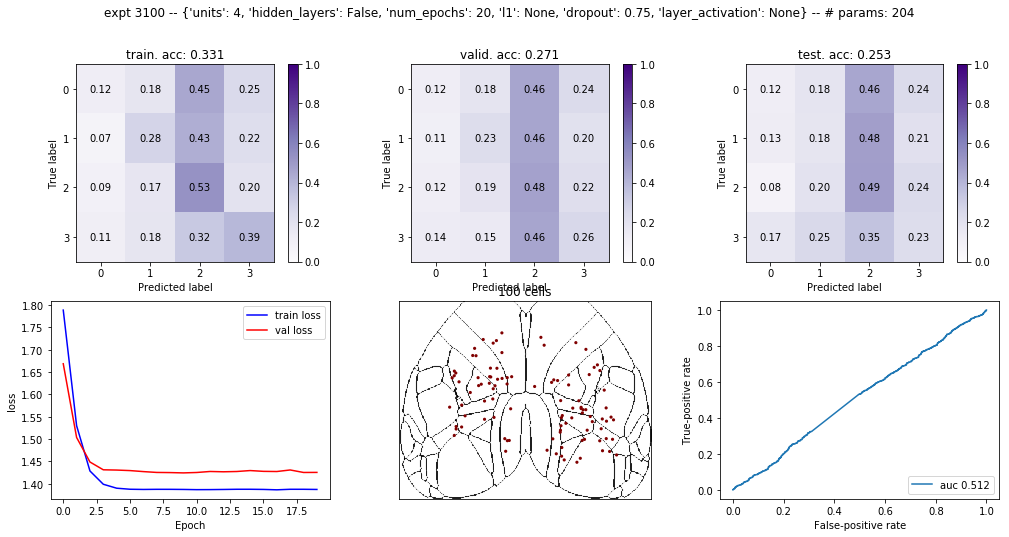

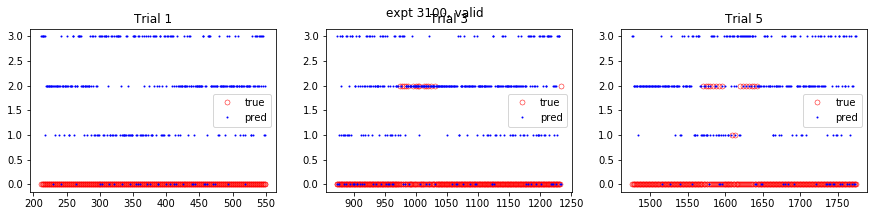

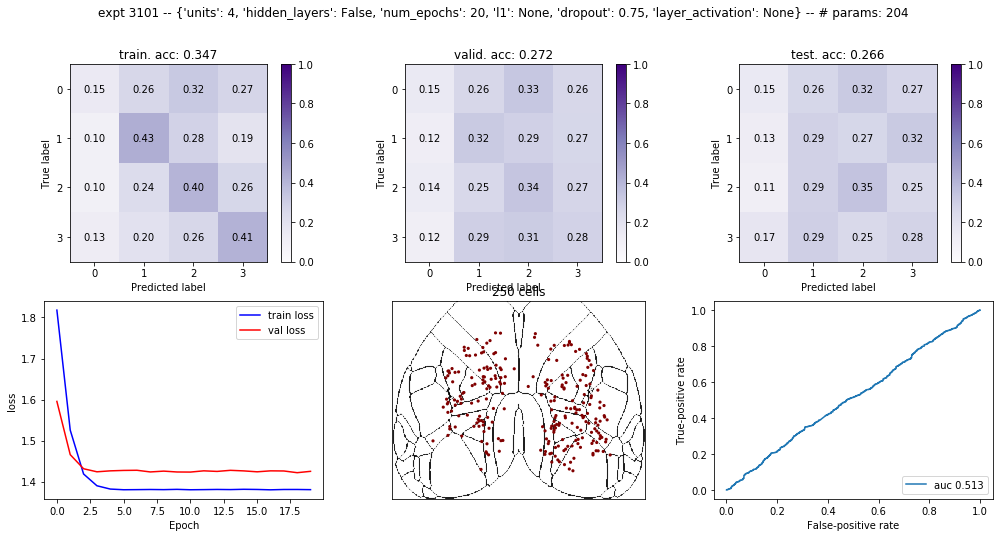

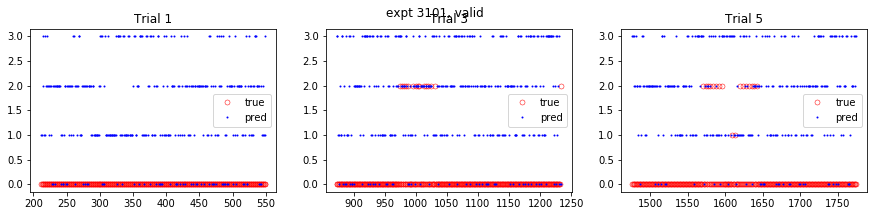

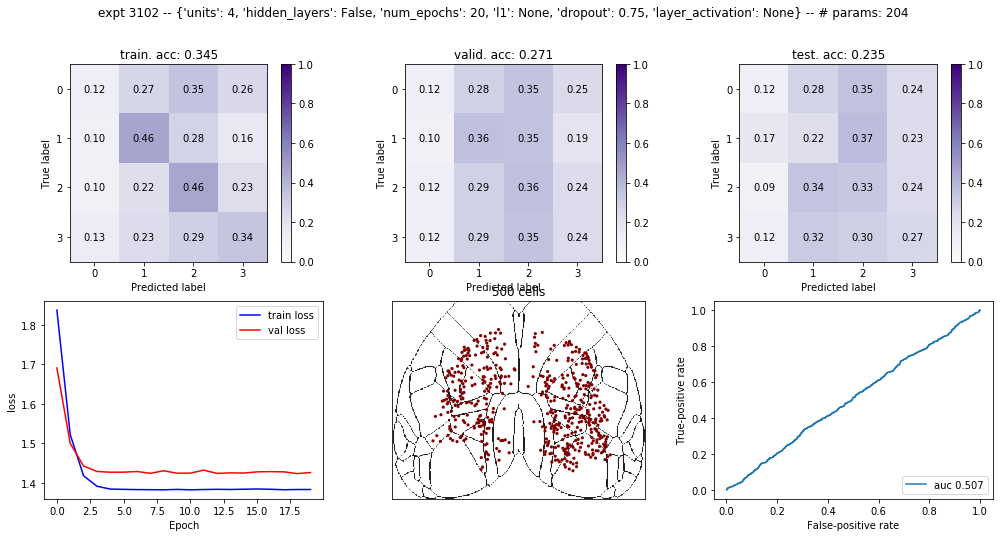

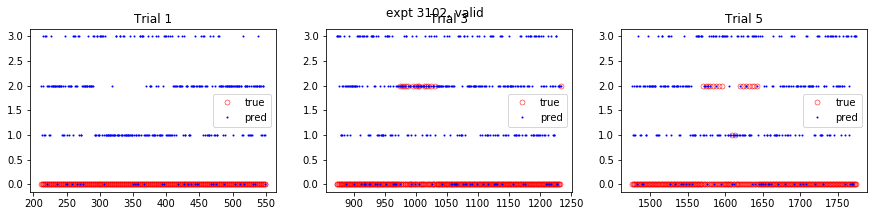

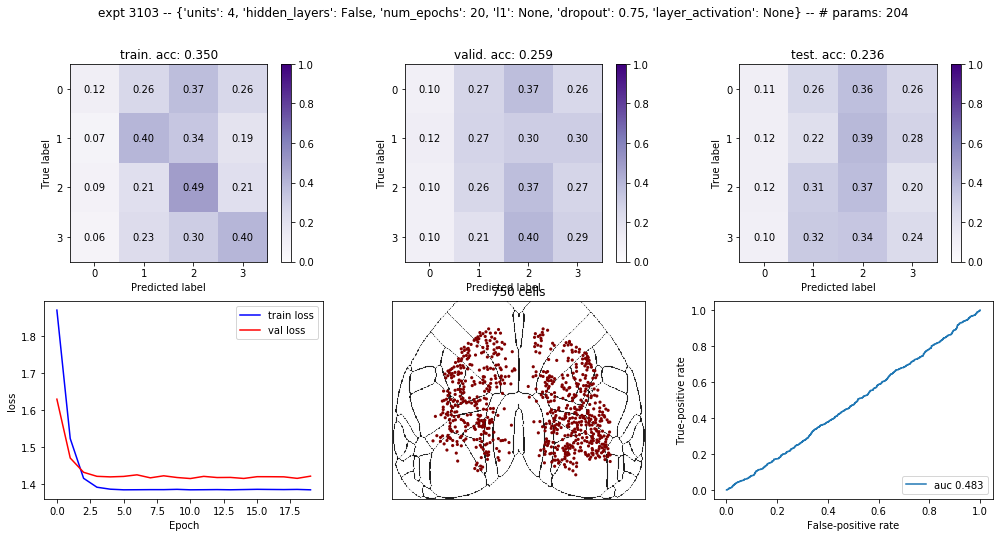

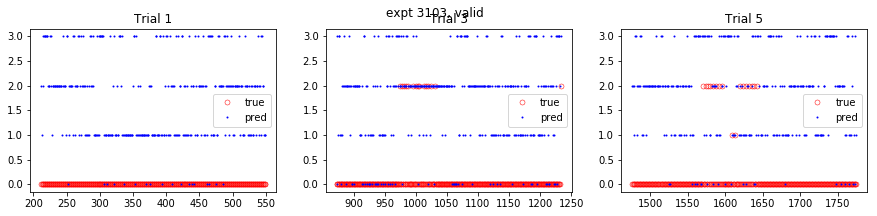

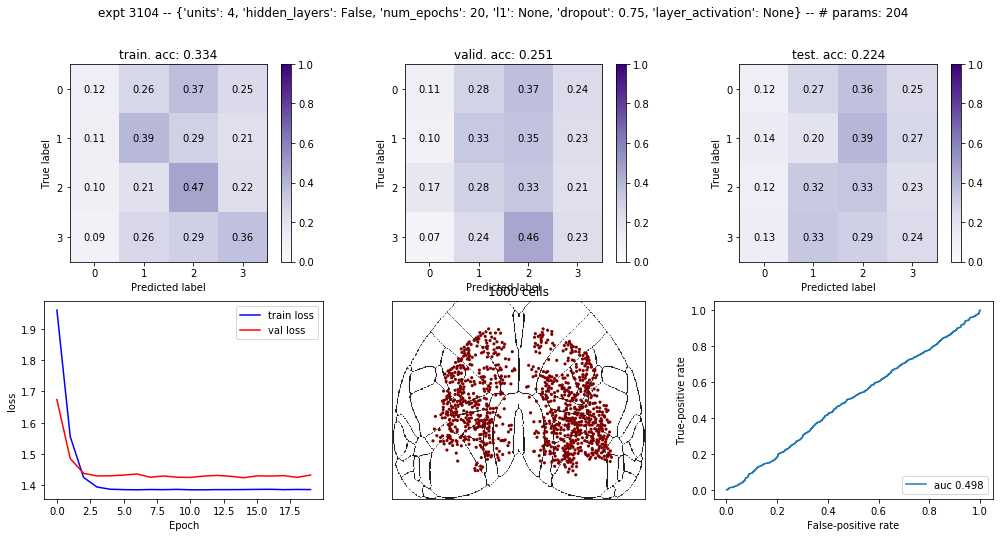

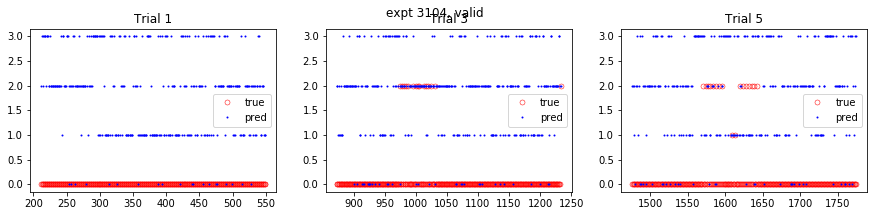

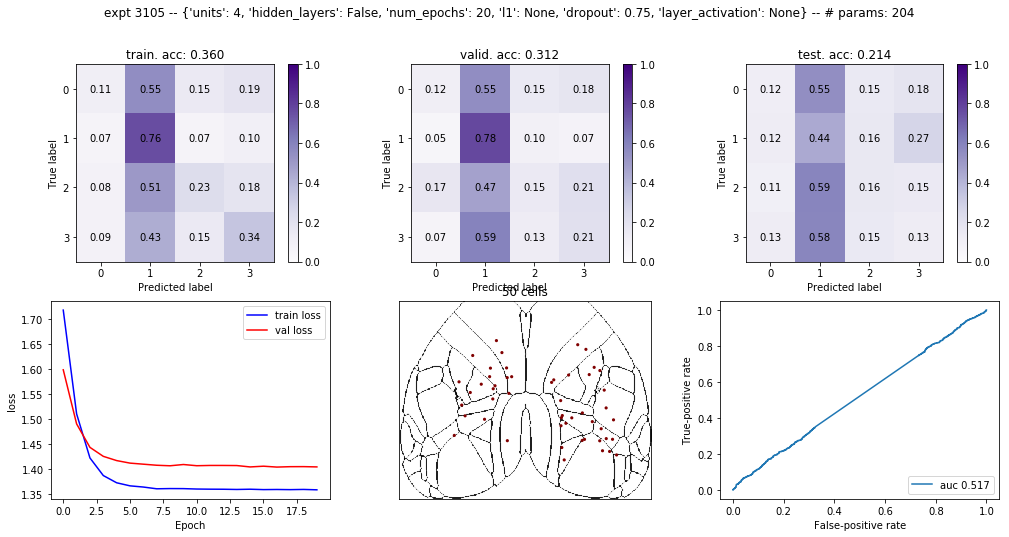

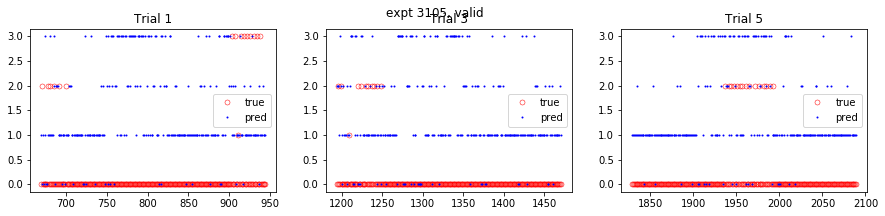

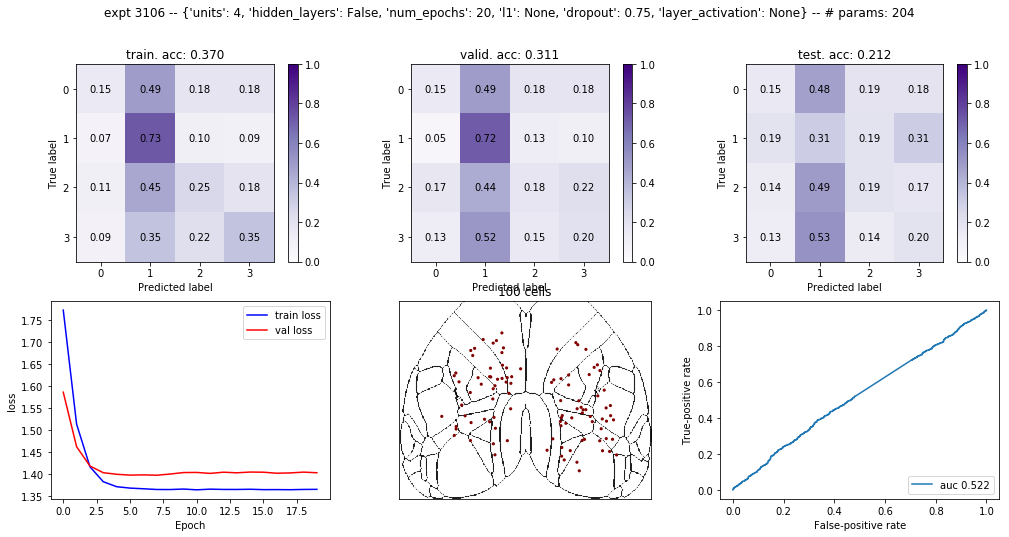

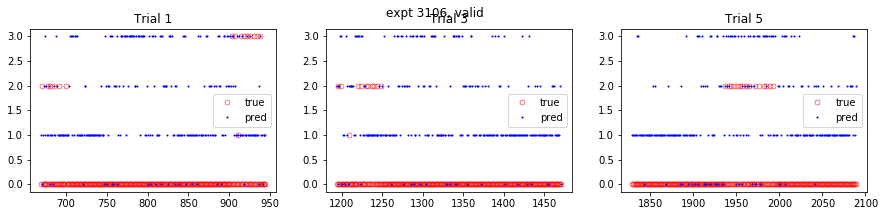

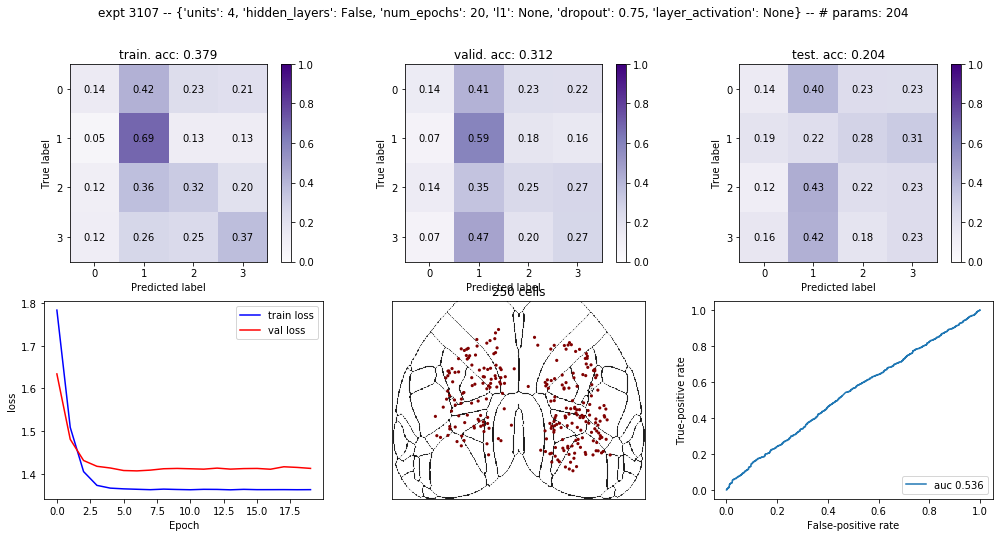

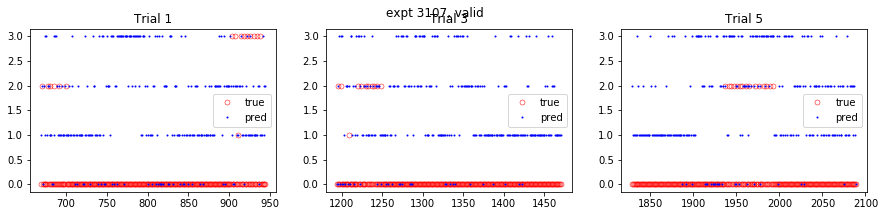

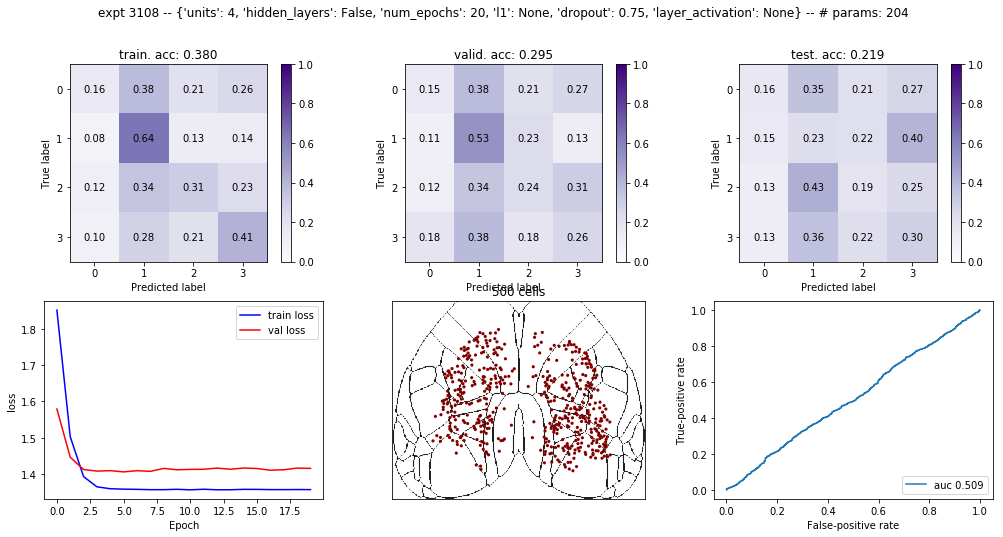

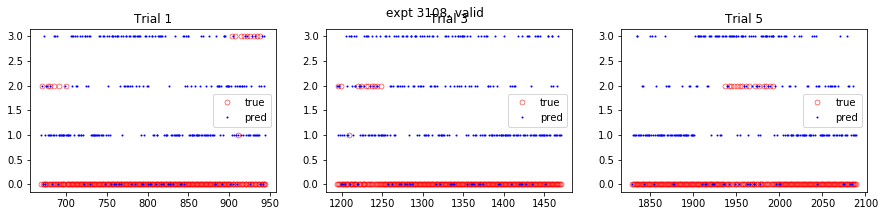

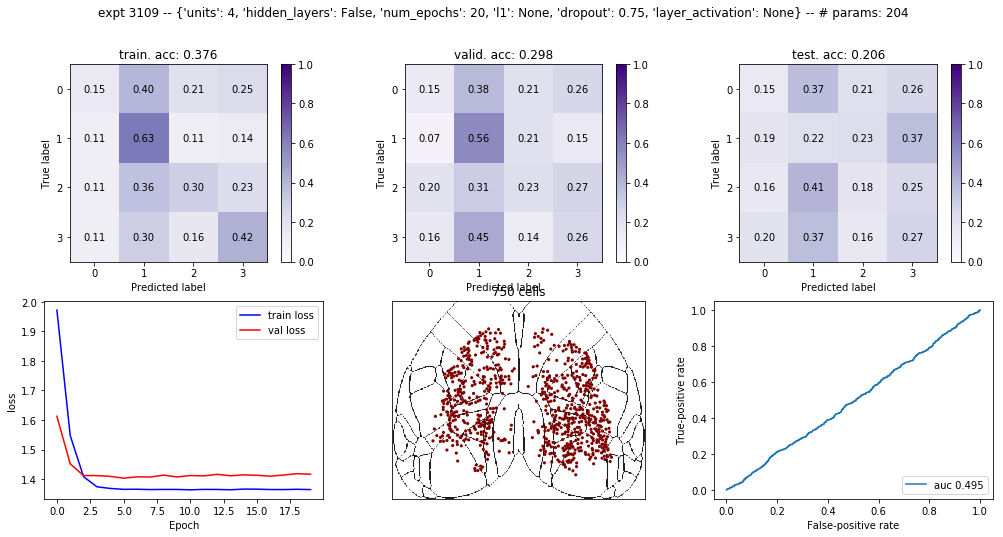

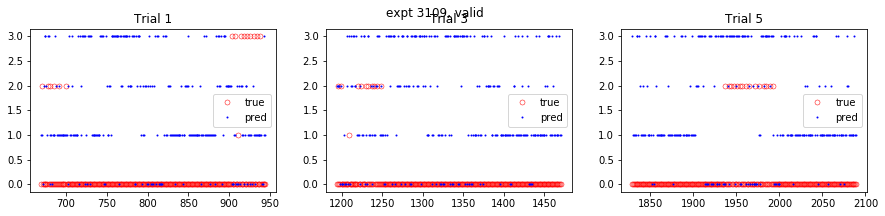

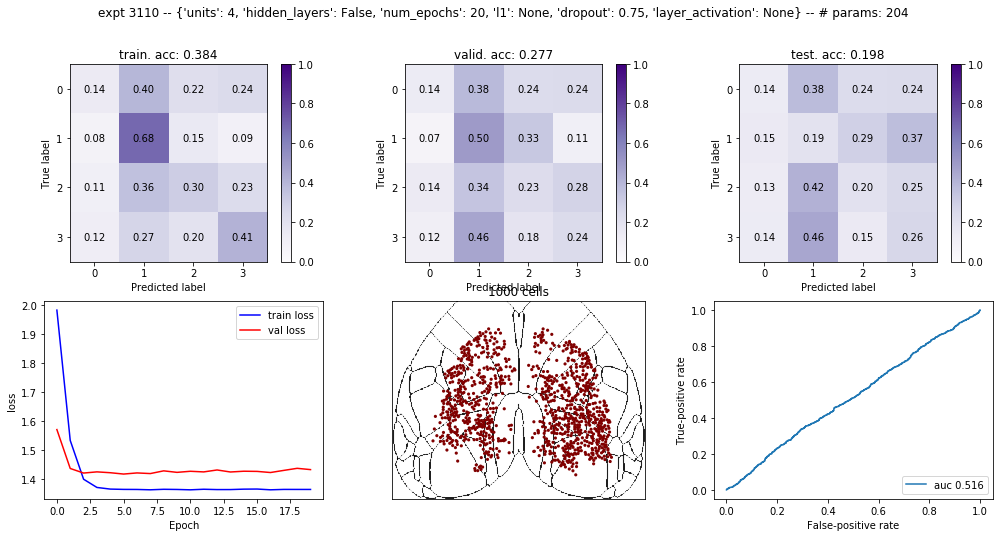

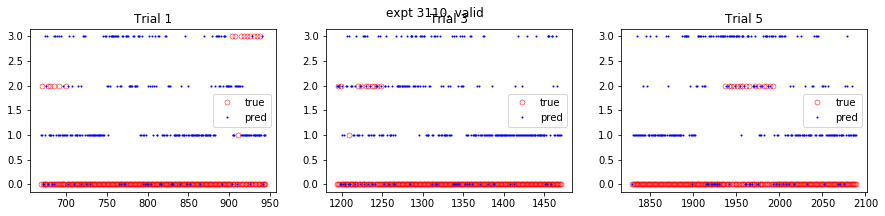

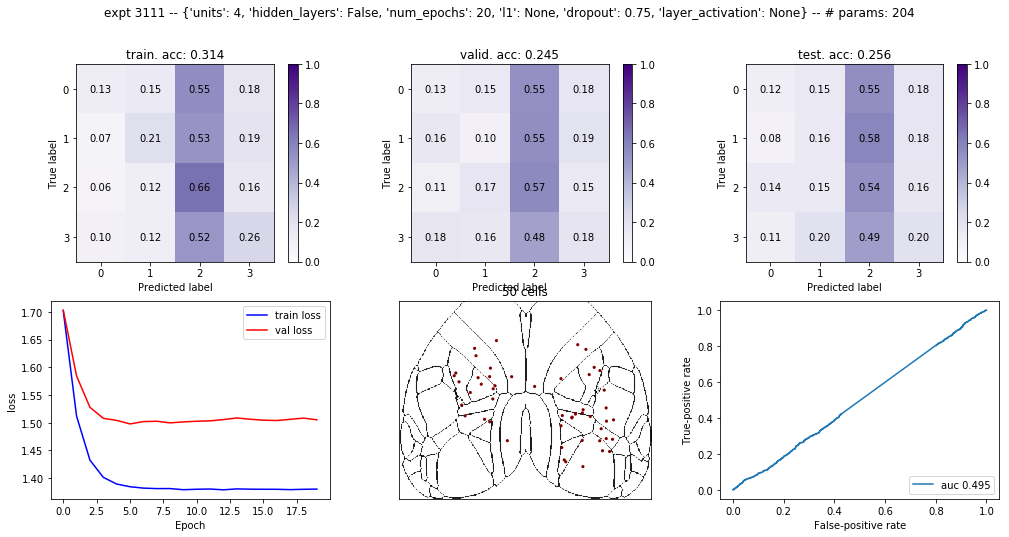

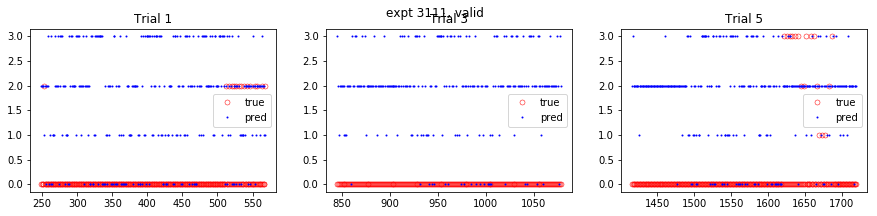

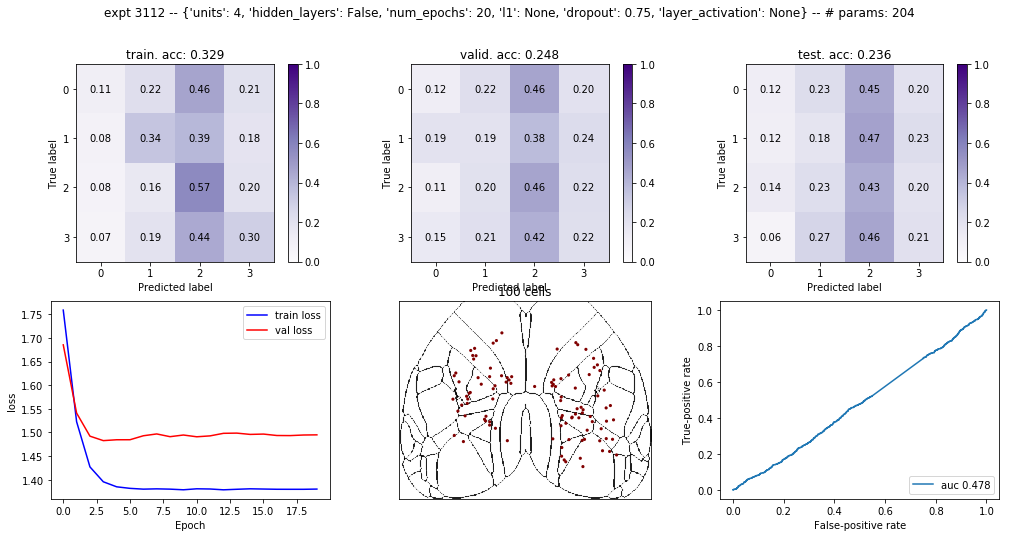

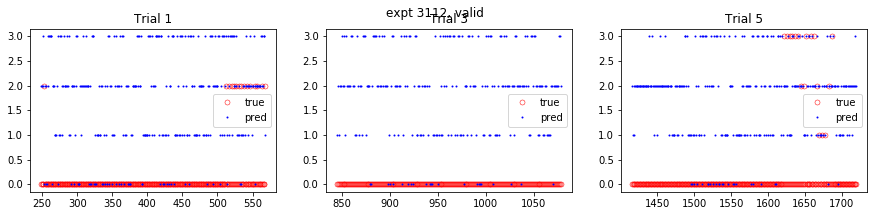

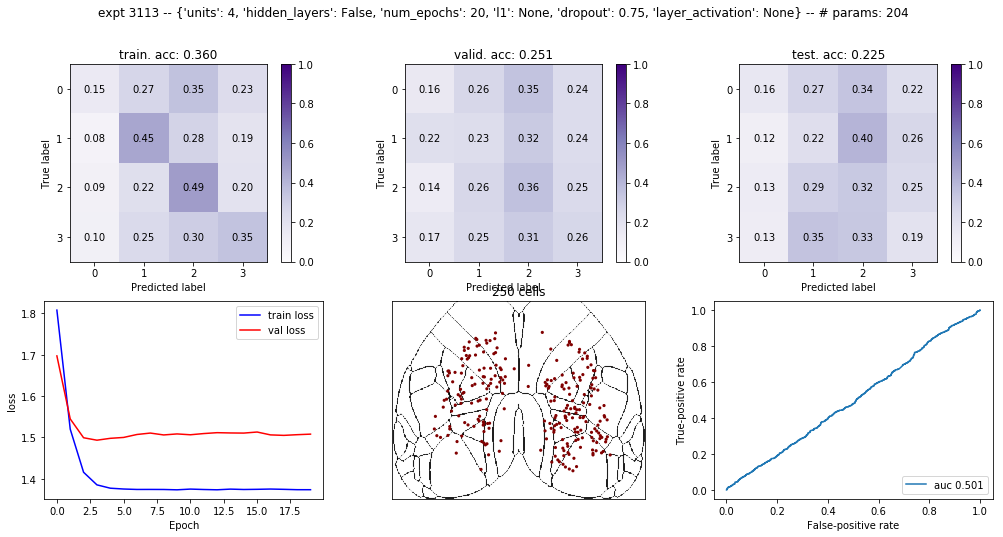

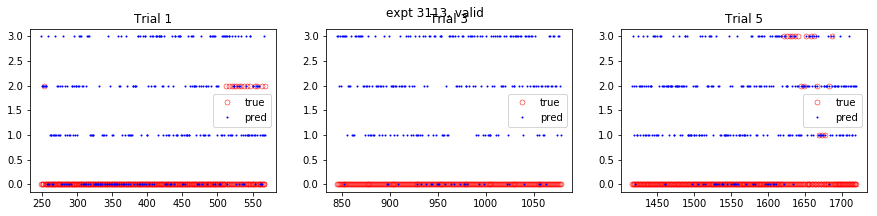

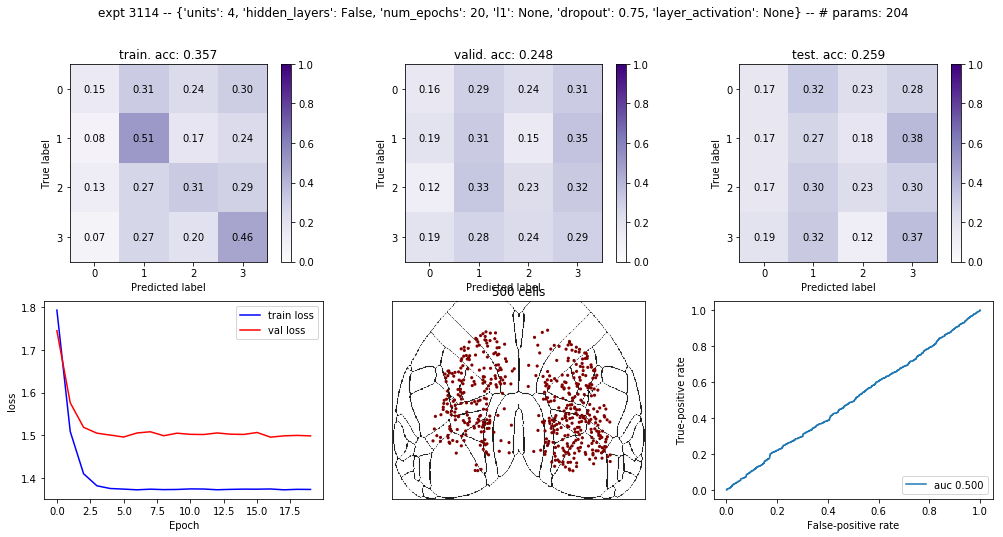

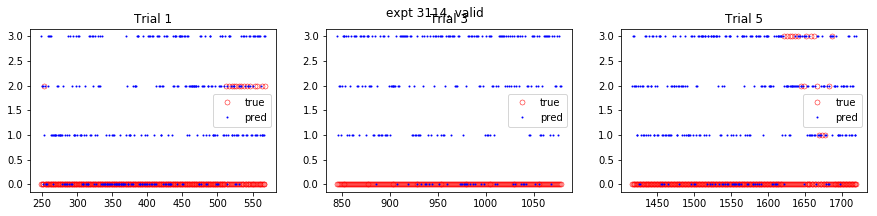

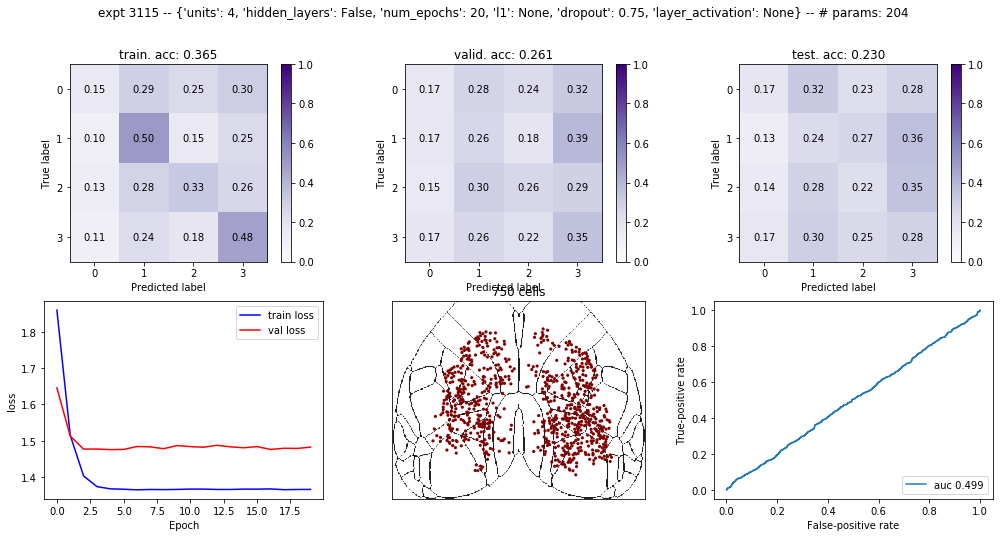

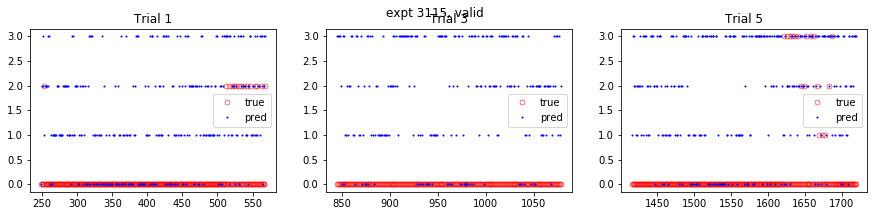

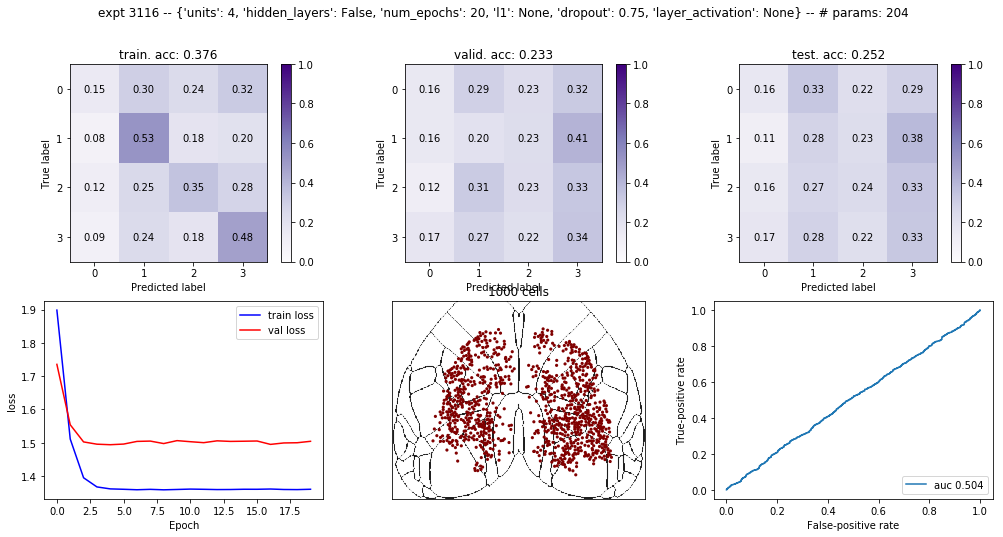

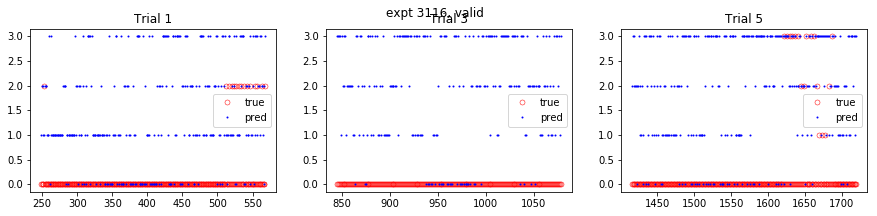

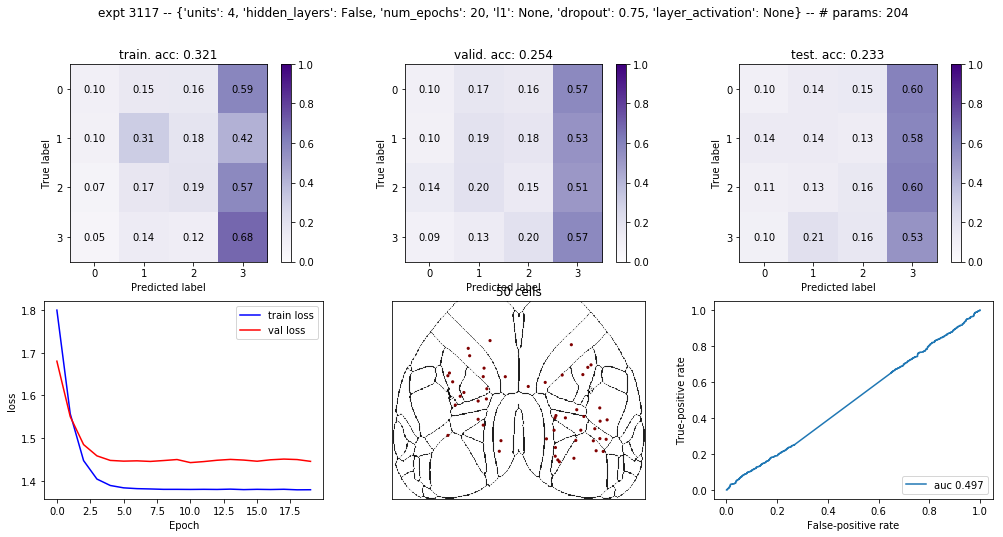

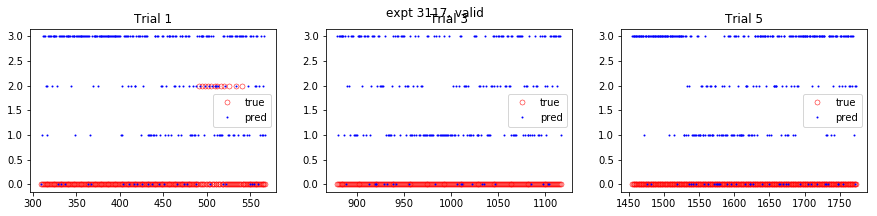

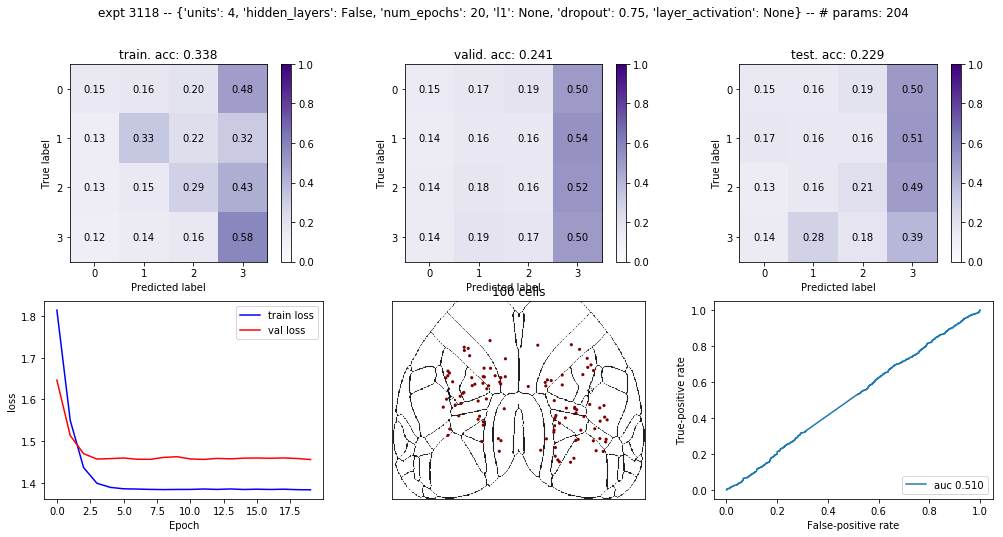

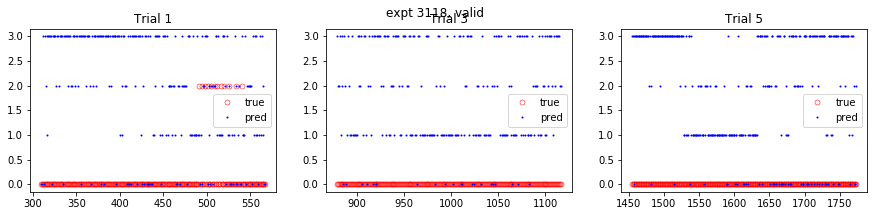

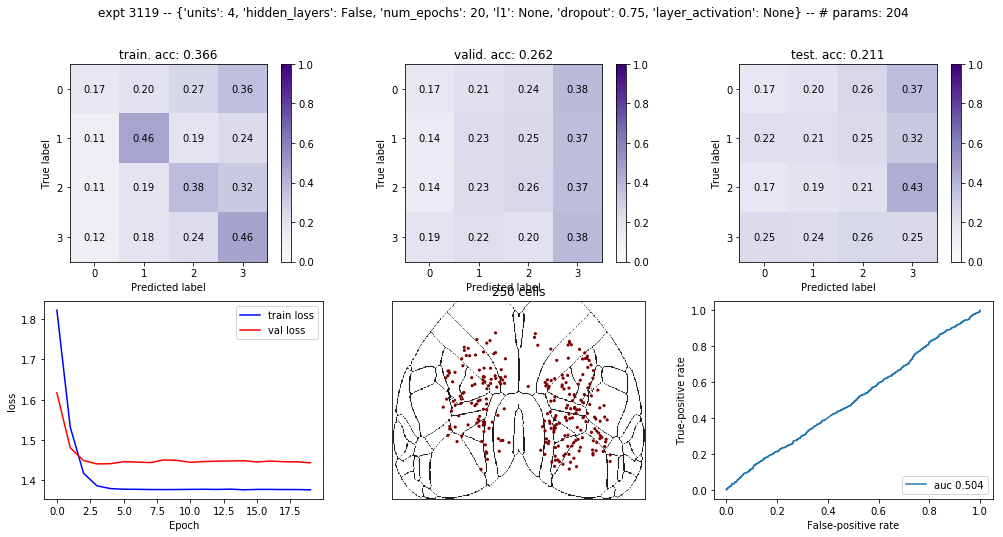

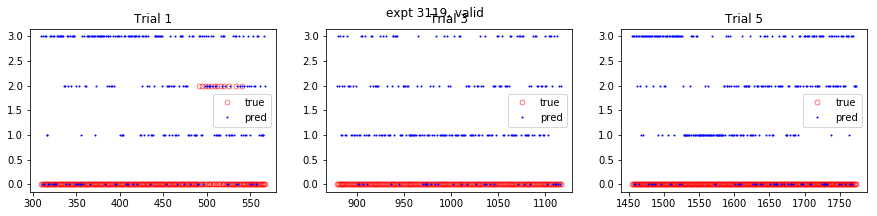

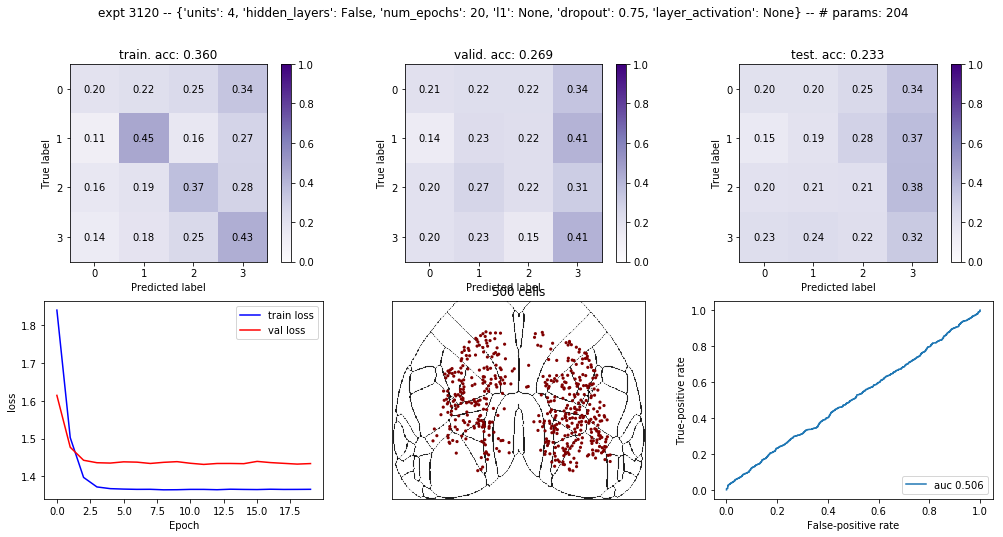

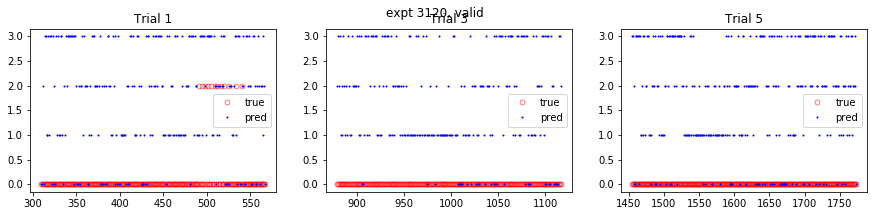

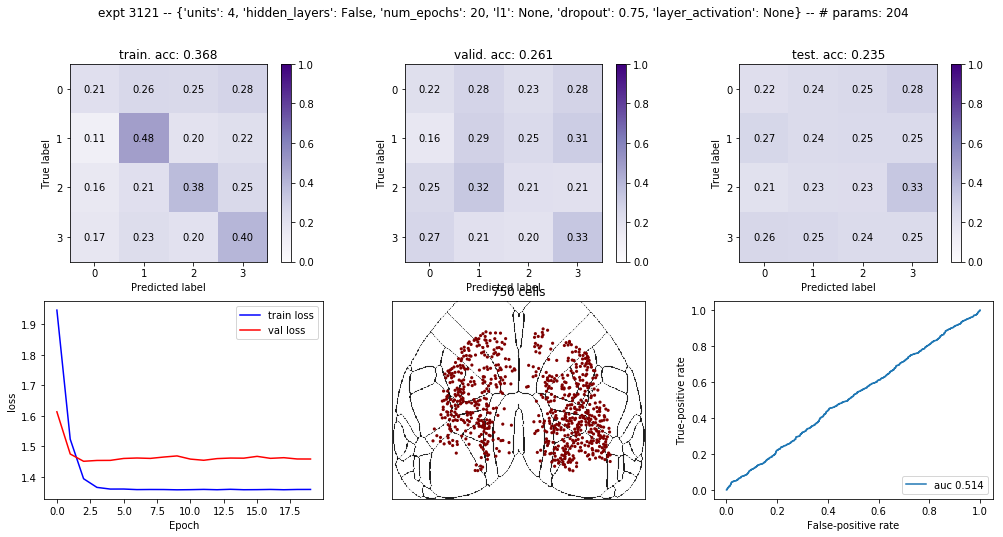

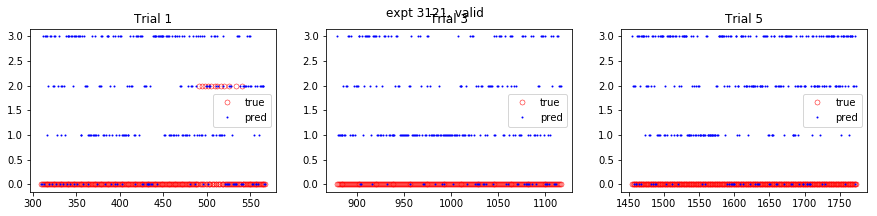

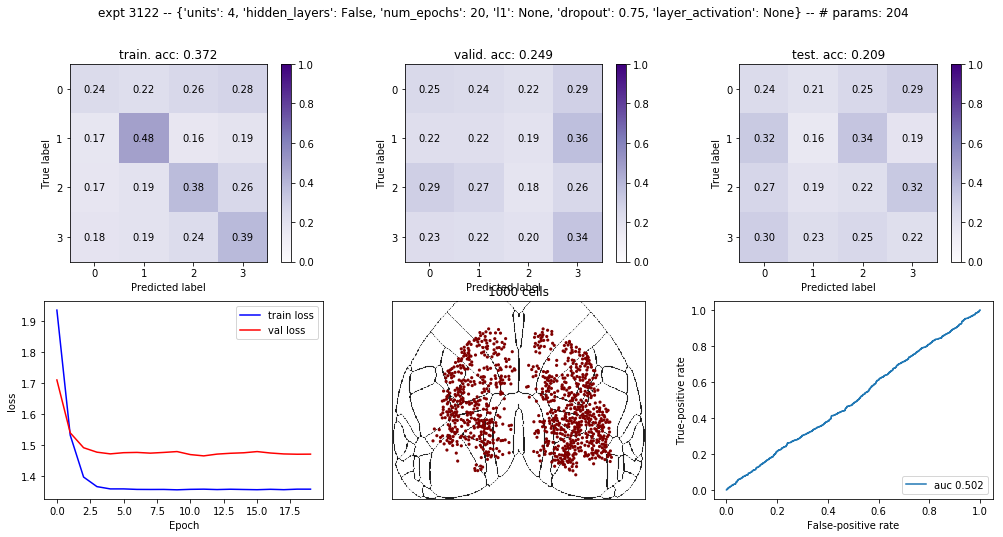

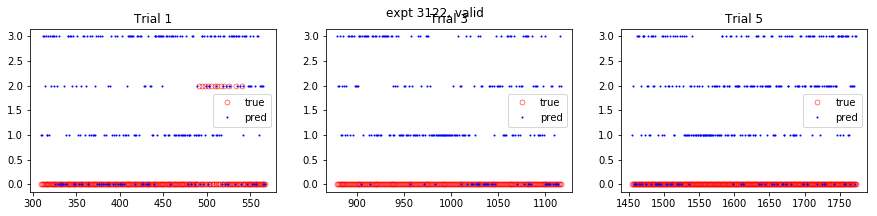

In [10]:
#### NOW RUN ON SHUFFLED DATA for each experiment
from cosmos.traces.lick_decoder import LickDecoder

### See du.select_experiment_group for information on the different expt_group_id's.
### Key groups: 8, 9, 4, 10

all_expts_str = []
T0 = time.time()

for expt_group_id in [8, 9, 4, 10]: #[8, 9, 4]: #[8, 9, 4, 10]:
    LD = LickDecoder(dataset_id, CT, decoding_save_dir, just_decode_licks=False)

    expts_info, expts_str = LD.decode_licks(nfolds=4, #1, #4 
                                            expt_group_id=expt_group_id, ### Make '0' for do_single_experiment
                                            do_pca = True,
                                            n_pca_components = 75, #75 ## CHANGE THIS BACK IF > 75 neurons
                                            do_shuffle_data = True)
    all_expts_str.append(expts_str)
print('Overall time in seconds:')
print(time.time() - T0)

In [11]:
all_expts_str

["'id': 7, 'expt_nums': np.arange(3099, 3123),'expt_type': 'nneurons', 'info':8"]

{'standardize_X': True, 'train_frac': 0.5, 'valid_frac': 0.25, 'test_frac': 0.25, 'bins_before': 0, 'decoding_set': 1, 'rand_seed': 0, 'bins_current': 1, 'bins_after': 0, 'remove_multi_licks': False, 'center_Y': True, 'train_feat': 'spikes'}
Data split into train, test, validate sets. 
Fractions: Train 0.493, Test 0.245 Valid 0.253
Z-scoring X!!
Max X 69.555675567883
X_train: (30191, 1, 1240) X_test: (15012, 1, 1240)
# experiments: 1
Expt range: 3071 to 3071
Expt 3071, setting rand, nneurons 1240
Using circular permutation shuffle.
EVR: 0.10944596886732358
--->Using NONLINEAR model
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003071


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


242.18319869041443
Total time: 242.20627
Data split into train, test, validate sets. 
Fractions: Train 0.502, Test 0.242 Valid 0.245
Z-scoring X!!
Max X 54.8126551625709
X_train: (30773, 1, 1240) X_test: (14805, 1, 1240)
# experiments: 1
Expt range: 3072 to 3072
Expt 3072, setting rand, nneurons 1240
Using circular permutation shuffle.
EVR: 0.10936480515723404
--->Using NONLINEAR model
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003072


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


257.2501266002655
Total time: 257.27385
Data split into train, test, validate sets. 
Fractions: Train 0.502, Test 0.247 Valid 0.241
Z-scoring X!!
Max X 59.43387495908256
X_train: (30763, 1, 1240) X_test: (15143, 1, 1240)
# experiments: 1
Expt range: 3073 to 3073
Expt 3073, setting rand, nneurons 1240
Using circular permutation shuffle.
EVR: 0.1083147648708797
--->Using NONLINEAR model
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003073


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


253.89550805091858
Total time: 253.91901
Data split into train, test, validate sets. 
Fractions: Train 0.492, Test 0.253 Valid 0.245
Z-scoring X!!
Max X 74.05257730360735
X_train: (30155, 1, 1240) X_test: (15480, 1, 1240)
# experiments: 1
Expt range: 3074 to 3074
Expt 3074, setting rand, nneurons 1240
Using circular permutation shuffle.
EVR: 0.1087353259090481
--->Using NONLINEAR model
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/7/expt_003074


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


247.27179741859436
Total time: 247.29512
Overall time in seconds:
1039.2510585784912


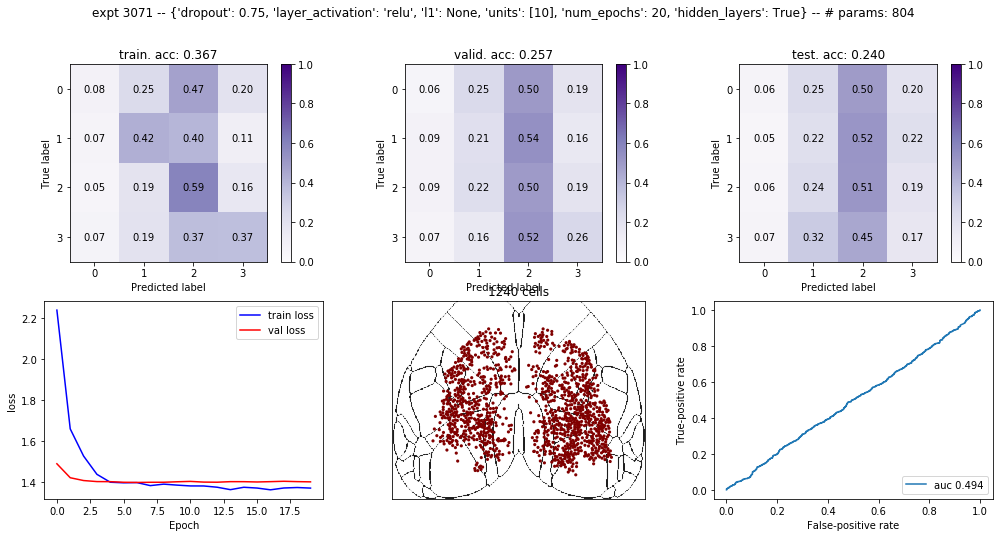

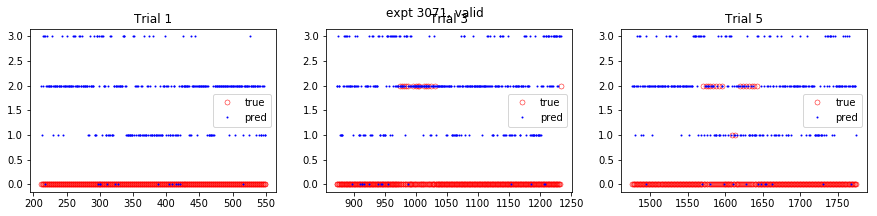

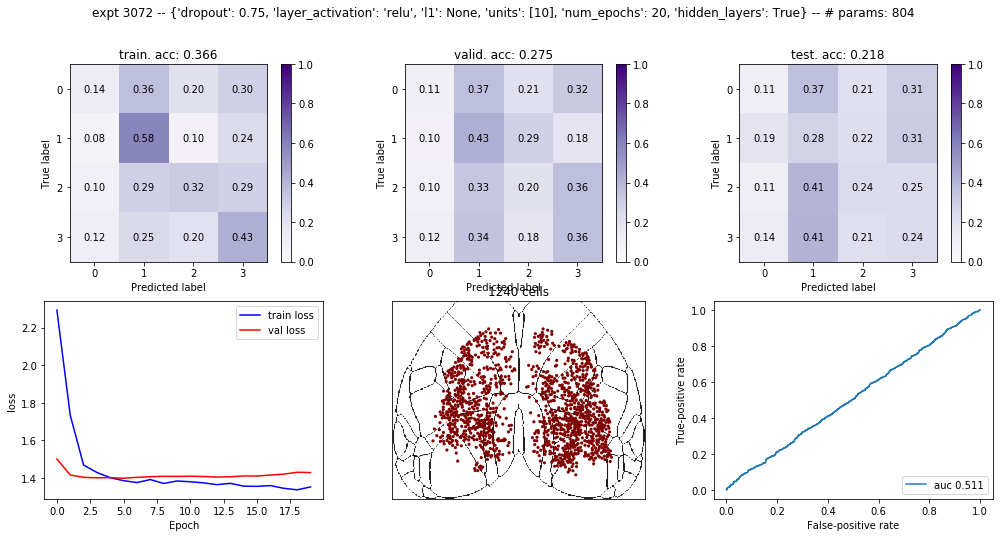

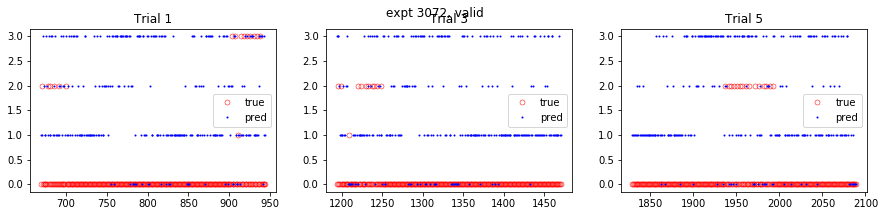

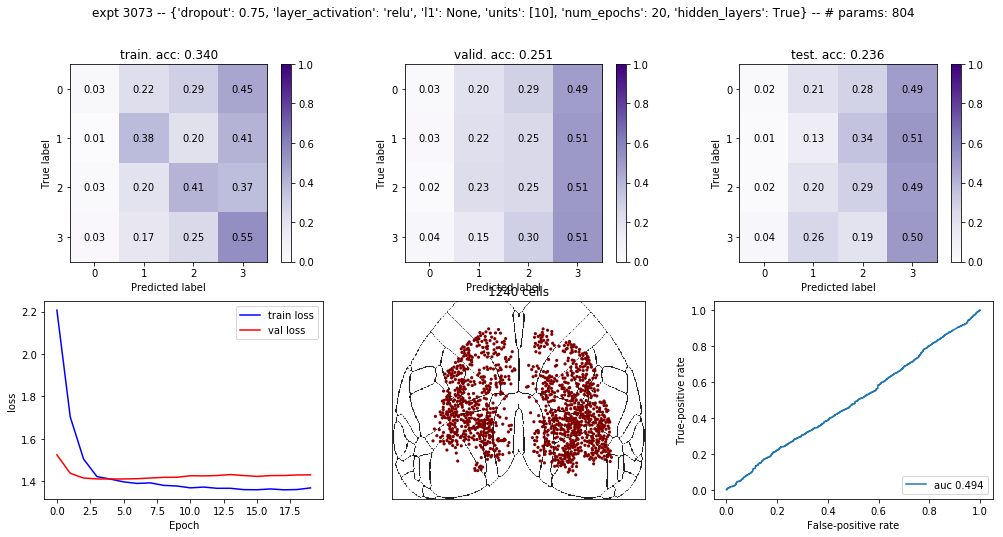

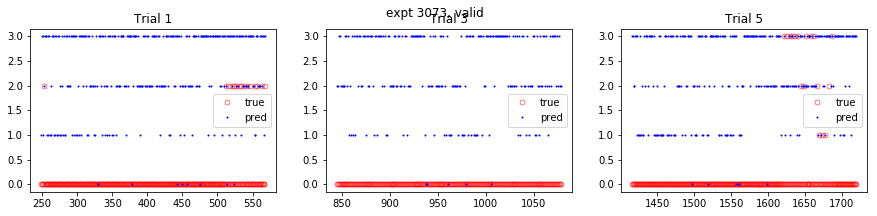

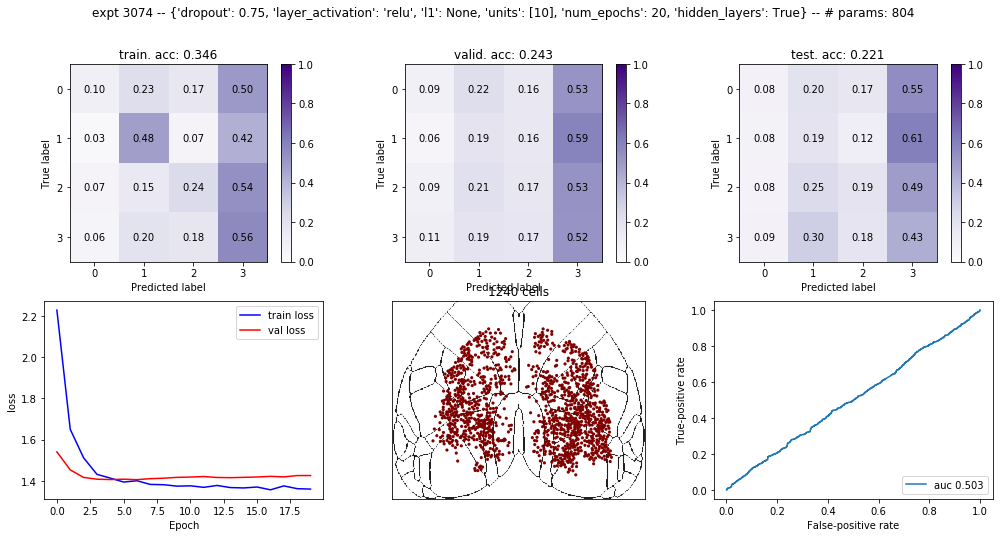

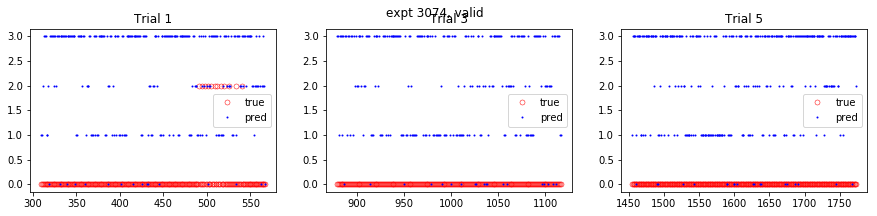

In [16]:
#### NOW RUN ON SHUFFLED DATA (just with all sources)
from cosmos.traces.lick_decoder import LickDecoder

### See du.select_experiment_group for information on the different expt_group_id's.
### Key groups: 8, 9, 4, 10

all_expts_str = []
T0 = time.time()

for expt_group_id in [10]: #[8, 9, 4, 10]: #[8, 9, 4]: #[8, 9, 4, 10]:
    LD = LickDecoder(dataset_id, CT, decoding_save_dir, just_decode_licks=False)

    expts_info, expts_str = LD.decode_licks(nfolds=4, #1, #4 
                                            expt_group_id=expt_group_id, ### Make '0' for do_single_experiment
                                            do_pca = True,
                                            n_pca_components = 75, #75
                                            do_shuffle_data = True)
    all_expts_str.append(expts_str)
print('Overall time in seconds:')
print(time.time() - T0)

In [17]:
all_expts_str

["'id': 7, 'expt_nums': np.arange(3071, 3075),'expt_type': 'neuron_set', 'info':10"]

In [ ]:
concluded_expts = {
    
    
### Now with 50 pcs
["'id': 7, 'expt_nums': np.arange(3075, 3099),'expt_type': 'nneurons', 'info':8"]
["'id': 11, 'expt_nums': np.arange(1518, 1542),'expt_type': 'nneurons', 'info':8"]
["'id': 18, 'expt_nums': np.arange(1273, 1297),'expt_type': 'nneurons', 'info':8"]
    ["'id': 19, 'expt_nums': np.arange(1529, 1553),'expt_type': 'nneurons', 'info':8"]
    
### Now with 50 pcs, shuffled. 
["'id': 7, 'expt_nums': np.arange(3099, 3123),'expt_type': 'nneurons', 'info':8"]
["'id': 11, 'expt_nums': np.arange(1542, 1566),'expt_type': 'nneurons', 'info':8"]
["'id': 18, 'expt_nums': np.arange(1297, 1321),'expt_type': 'nneurons', 'info':8"]
["'id': 19, 'expt_nums': np.arange(1553, 1577),'expt_type': 'nneurons', 'info':8"]
    
### The below are not shuffled, 4way decoding. Nonlinear model. 1 bins centered. 75 neurons. 
###    X-standardized! NON-BINARIZED. 20200108
["'id': 7, 'expt_nums': np.arange(2935, 2955),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2955, 2979),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2979, 2999),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2999, 3003),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1378, 1398),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1398, 1422),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1422, 1442),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1442, 1446),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(1133, 1153),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1153, 1177),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1177, 1197),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1197, 1201),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1389, 1409),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1409, 1433),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1433, 1453),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1453, 1457),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(291, 311),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(311, 335),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(335, 355),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(355, 359),'expt_type': 'neuron_set', 'info':10"]
    
### The below are circularly shuffled, 4way decoding. Nonlinear model. 1 bins centered. 75 neurons. 
###    X-standardized! NON-BINARIZED. 20200108
["'id': 7, 'expt_nums': np.arange(3003, 3023),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(3023, 3047),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(3047, 3067),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(3067, 3071),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1446, 1466),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1466, 1490),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1490, 1510),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1510, 1514),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(1201, 1221),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1221, 1245),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1245, 1265),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1265, 1269),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1457, 1477),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1477, 1501),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1501, 1521),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1521, 1525),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(359, 379),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(379, 403),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(403, 423),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(423, 427),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are circularly shuffled, 4way decoding. Nonlinear model. 1 bins centered. 75 neurons. 
###    X-standardized! NON-BINARIZED. 20200108
["'id': 7, 'expt_nums': np.arange(3071, 3075),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1514, 1518),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(1269, 1273),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1525, 1529),'expt_type': 'neuron_set', 'info':10"]

    
    
    
### The below are not shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(989, 1009),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1009, 1033),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1033, 1053),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1053, 1057),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2788, 2808),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2808, 2832),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2832, 2852),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2852, 2856),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 11, 'expt_nums': np.arange(1234, 1254),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1254, 1278),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1278, 1298),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1298, 1302),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1245, 1265),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1265, 1289),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1289, 1309),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1309, 1313),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 35, 'expt_nums': np.arange(145, 165),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(165, 189),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(189, 209),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(209, 213),'expt_type': 'neuron_set', 'info':10"]
    
### The below are shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(1057, 1061),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2856, 2860),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1302, 1306),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1313, 1317),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(213, 217),'expt_type': 'neuron_set', 'info':10"]
    
### The below are circular shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(1061, 1065),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2860, 2864),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1317, 1321),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1306, 1310),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(219, 223),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are CIRCULAR shuffled, 4way decoding. 1 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20191211
["'id': 18, 'expt_nums': np.arange(1065, 1085),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(1085, 1109),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(1109, 1129),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(1129, 1133),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 7, 'expt_nums': np.arange(2864, 2884),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2884, 2908),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2908, 2928),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2928, 2932),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1310, 1330),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1330, 1354),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1354, 1374),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1374, 1378),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1321, 1341),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1341, 1365),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1365, 1385),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1385, 1389),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(223, 243),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(243, 267),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(267, 287),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(287, 291),'expt_type': 'neuron_set', 'info':10"]
    
    
    
    
    
### The below are not shuffled, 4way decoding. 3 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20190814
["'id': 18, 'expt_nums': np.arange(917, 937),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(937, 961),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(961, 981),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(981, 985),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2716, 2736),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2736, 2760),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2760, 2780),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2780, 2784),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1162, 1182),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1182, 1206),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1206, 1226),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1226, 1230),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1173, 1193),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1193, 1217),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1217, 1237),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1237, 1241),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(73, 93),'expt_type': 'nneurons', 'info':8",
 "'id': 35, 'expt_nums': np.arange(93, 117),'expt_type': 'neuron_set', 'info':9",
 "'id': 35, 'expt_nums': np.arange(117, 137),'expt_type': 'neuron_set', 'info':4",
 "'id': 35, 'expt_nums': np.arange(137, 141),'expt_type': 'neuron_set', 'info':10"]
    
### The below are shuffled, 4way decoding. 3 bins centered. 75 neurons. X-standardized! NON-BINARIZED. 20190814
["'id': 18, 'expt_nums': np.arange(985, 989),'expt_type': 'neuron_set', 'info':10"]
["'id': 7, 'expt_nums': np.arange(2784, 2788),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1230, 1234),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1241, 1245),'expt_type': 'neuron_set', 'info':10"]
["'id': 35, 'expt_nums': np.arange(141, 145),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are not shuffled, 4way decoding. 3 bins centered on timepoint. 75 neurons. NON-BINARIZED. 20190814
["'id': 7, 'expt_nums': np.arange(2644, 2664),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2664, 2688),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2688, 2708),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2708, 2712),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 11, 'expt_nums': np.arange(1090, 1110),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1110, 1134),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1134, 1154),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1154, 1158),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 18, 'expt_nums': np.arange(842, 862),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(862, 886),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(886, 906),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(906, 910),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1101, 1121),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1121, 1145),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1145, 1165),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1165, 1169),'expt_type': 'neuron_set', 'info':10"]
    
    
### The below are shuffled, 4way decoding. 3 bins centered on timepoint. 75 neurons. NON-BINARIZED. 20190814
["'id': 7, 'expt_nums': np.arange(2712, 2716),'expt_type': 'neuron_set', 'info':10"]
    ["'id': 11, 'expt_nums': np.arange(1158, 1162),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(910, 914),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1169, 1173),'expt_type': 'neuron_set', 'info':10"]

    
    
    
    
    
    ### The below are not shuffled. 4way decoding. 3 bins centered on timepoint. 75 neurons.
["'id': 7, 'expt_nums': np.arange(2572, 2592),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2592, 2616),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2616, 2636),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2636, 2640),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(770, 790),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(790, 814),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(814, 834),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(834, 838),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1029, 1049),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(1049, 1073),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(1073, 1093),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(1093, 1097),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1018, 1038),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(1038, 1062),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(1062, 1082),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(1082, 1086),'expt_type': 'neuron_set', 'info':10"]
    
    ### The below are shuffled. 4way decoding. 3 bins centered on timepoint. 75 neurons.
["'id': 7, 'expt_nums': np.arange(2640, 2644),'expt_type': 'neuron_set', 'info':10"]
["'id': 18, 'expt_nums': np.arange(838, 842),'expt_type': 'neuron_set', 'info':10"]
["'id': 19, 'expt_nums': np.arange(1097, 1101),'expt_type': 'neuron_set', 'info':10"]
["'id': 11, 'expt_nums': np.arange(1086, 1090),'expt_type': 'neuron_set', 'info':10"]
}



# concluded_expts = {
#     ### The below are not shuffled. 4way decoding. 2 bins before and during timepoint.
# ["'id': 7, 'expt_nums': np.arange(2500, 2520),'expt_type': 'nneurons', 'info':8",
#  "'id': 7, 'expt_nums': np.arange(2520, 2544),'expt_type': 'neuron_set', 'info':9",
#  "'id': 7, 'expt_nums': np.arange(2544, 2564),'expt_type': 'neuron_set', 'info':4",
#  "'id': 7, 'expt_nums': np.arange(2564, 2568),'expt_type': 'neuron_set', 'info':10"]
    
# ["'id': 18, 'expt_nums': np.arange(698, 718),'expt_type': 'nneurons', 'info':8",
#  "'id': 18, 'expt_nums': np.arange(718, 742),'expt_type': 'neuron_set', 'info':9",
#  "'id': 18, 'expt_nums': np.arange(742, 762),'expt_type': 'neuron_set', 'info':4",
#  "'id': 18, 'expt_nums': np.arange(762, 766),'expt_type': 'neuron_set', 'info':10"]
    
# ["'id': 19, 'expt_nums': np.arange(957, 977),'expt_type': 'nneurons', 'info':8",
#  "'id': 19, 'expt_nums': np.arange(977, 1001),'expt_type': 'neuron_set', 'info':9",
#  "'id': 19, 'expt_nums': np.arange(1001, 1021),'expt_type': 'neuron_set', 'info':4",
#  "'id': 19, 'expt_nums': np.arange(1021, 1025),'expt_type': 'neuron_set', 'info':10"]
    
# ["'id': 11, 'expt_nums': np.arange(946, 966),'expt_type': 'nneurons', 'info':8",
#  "'id': 11, 'expt_nums': np.arange(966, 990),'expt_type': 'neuron_set', 'info':9",
#  "'id': 11, 'expt_nums': np.arange(990, 1010),'expt_type': 'neuron_set', 'info':4",
#  "'id': 11, 'expt_nums': np.arange(1010, 1014),'expt_type': 'neuron_set', 'info':10"]
    
#     ### The below are shuffled. 4way decoding. 2 bins before and during timepoint.
#     ["'id': 7, 'expt_nums': np.arange(2568, 2572),'expt_type': 'neuron_set', 'info':10"]
#     ["'id': 18, 'expt_nums': np.arange(766, 770),'expt_type': 'neuron_set', 'info':10"]
#     ["'id': 19, 'expt_nums': np.arange(1025, 1029),'expt_type': 'neuron_set', 'info':10"]
#     ["'id': 11, 'expt_nums': np.arange(1014, 1018),'expt_type': 'neuron_set', 'info':10"]
    
# }


In [341]:
concluded_expts = {
    0: {'id': 19, 'expt_nums': np.arange(664, 668),'expt_type': 'neuron_set', 'info':10}, # not shuffled
    1: {'id': 19, 'expt_nums': np.arange(668, 672),'expt_type': 'neuron_set', 'info':10}, # shuffled
    2: {'id': 18, 'expt_nums': np.arange(327, 331),'expt_type': 'neuron_set', 'info':10}, # not shuffled
    3: {'id': 18, 'expt_nums': np.arange(331, 335),'expt_type': 'neuron_set', 'info':10}, # shuffled
    4: {'id': 11, 'expt_nums': np.arange(604, 608),'expt_type': 'neuron_set', 'info':10}, # not shuffled
    5: {'id': 11, 'expt_nums': np.arange(608, 612),'expt_type': 'neuron_set', 'info':10}, # shuffled
    6: {'id': 7, 'expt_nums': np.arange(2139, 2143),'expt_type': 'neuron_set', 'info':10}, # not shuffled
    7: {'id': 7, 'expt_nums': np.arange(2135, 2139),'expt_type': 'neuron_set', 'info':10}, # shuffled    
}

In [ ]:
### Recomputed with after fixed bug 11/6/18
concluded_expts = {
### The below are not shuffled. 4way decoding. 
    ["'id': 7, 'expt_nums': np.arange(2154, 2174),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2174, 2198),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2198, 2218),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2218, 2222),'expt_type': 'neuron_set', 'info':10"]
    
["'id': 11, 'expt_nums': np.arange(612, 632),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(632, 656),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(656, 676),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(676, 680),'expt_type': 'neuron_set', 'info':10"]
    
    ["'id': 18, 'expt_nums': np.arange(335, 355),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(355, 379),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(379, 399),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(399, 403),'expt_type': 'neuron_set', 'info':10"]
    
["'id': 19, 'expt_nums': np.arange(672, 692),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(692, 716),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(716, 736),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(736, 740),'expt_type': 'neuron_set', 'info':10"]

### The below are not shuffled. 3way decoding. 
["'id': 19, 'expt_nums': np.arange(740, 760),'expt_type': 'nneurons', 'info':8",
 "'id': 19, 'expt_nums': np.arange(760, 784),'expt_type': 'neuron_set', 'info':9",
 "'id': 19, 'expt_nums': np.arange(784, 804),'expt_type': 'neuron_set', 'info':4",
 "'id': 19, 'expt_nums': np.arange(804, 808),'expt_type': 'neuron_set', 'info':10"]
    
["'id': 18, 'expt_nums': np.arange(403, 423),'expt_type': 'nneurons', 'info':8",
 "'id': 18, 'expt_nums': np.arange(423, 447),'expt_type': 'neuron_set', 'info':9",
 "'id': 18, 'expt_nums': np.arange(447, 467),'expt_type': 'neuron_set', 'info':4",
 "'id': 18, 'expt_nums': np.arange(467, 471),'expt_type': 'neuron_set', 'info':10"]
    
["'id': 11, 'expt_nums': np.arange(680, 700),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(700, 724),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(724, 744),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(744, 748),'expt_type': 'neuron_set', 'info':10"]
    
["'id': 7, 'expt_nums': np.arange(2222, 2242),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2242, 2266),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2266, 2286),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2286, 2290),'expt_type': 'neuron_set', 'info':10"]

    
### 3-way decoding, shuffled
    ["'id': 7, 'expt_nums': np.arange(2290, 2310),'expt_type': 'nneurons', 'info':8",
 "'id': 7, 'expt_nums': np.arange(2310, 2334),'expt_type': 'neuron_set', 'info':9",
 "'id': 7, 'expt_nums': np.arange(2334, 2354),'expt_type': 'neuron_set', 'info':4",
 "'id': 7, 'expt_nums': np.arange(2354, 2358),'expt_type': 'neuron_set', 'info':10"]
    
    ["'id': 11, 'expt_nums': np.arange(748, 768),'expt_type': 'nneurons', 'info':8",
 "'id': 11, 'expt_nums': np.arange(768, 792),'expt_type': 'neuron_set', 'info':9",
 "'id': 11, 'expt_nums': np.arange(792, 812),'expt_type': 'neuron_set', 'info':4",
 "'id': 11, 'expt_nums': np.arange(812, 816),'expt_type': 'neuron_set', 'info':10"]
}


In [342]:
# ### Use the full load_decoding_experiments function. 


expt_id = 8
expt_group = concluded_expts[expt_id]
decoding_load_dir = os.path.join(data_dir, 'decoding_results', str(expt_group['id']))
expt_nums = expt_group['expt_nums']
expt_type = expt_group['expt_type']
metrics, expts_info = load_decoding_experiments(decoding_load_dir, expt_nums, which_metric='macro_auc')
accs_list, accs_names, expt_nums_organized = organize_decoding_experiments(metrics, expts_info, expt_type) #'nneurons', 'neuron_set', 'hemisphere'
# get_included_neuron_coverage(expts_info, param)
accs_names, accs_list


(array(['rand'], dtype='<U4'),
 [array([0.91815599, 0.90311743, 0.90676962, 0.92007326])])

In [ ]:
 [array([0.92065033, 0.89756722, 0.90475681, 0.9266761 ])])
In [ ]:


AUC: 0.91
AUC: 0.50


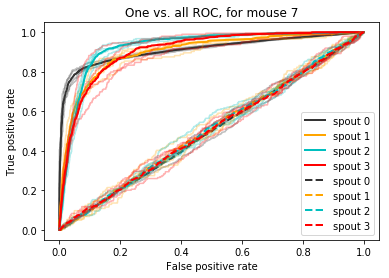

In [262]:
### Load decoding_summary directly. 

for expt_id in [6, 7]:
    expt_group = concluded_expts[expt_id]
    decoding_load_dir = os.path.join(data_dir, 'decoding_results', str(expt_group['id']))
    expt_nums = expt_group['expt_nums']


    fold_auc = []
    fold_informedness = []
    fold_fpr = defaultdict(list)
    fold_tpr = defaultdict(list)
    fold_cm = []
    for expt_num in expt_nums:
        expt_file = os.path.join(decoding_load_dir,
                                 'expt_{:06}'.format(expt_num))

        with open(expt_file + '_opts', "rb") as handle:
            opts = pickle.load(handle)
        with open(expt_file + '_decode_summary', "rb") as handle:
            decode_summary = pickle.load(handle)


        y_pred = decode_summary['y_pred']
        licks_true = decode_summary['licks_true']
        licks_pred = decode_summary['licks_pred']

        do_recompute_y_true = True ### There are two advantages: will not have any multi-label datapoints, also wasn't saved for prev classification
        if do_recompute_y_true:
            y_true = dict()
            for key in licks_true.keys():
                y_true[key] = keras.utils.to_categorical(licks_true[key])
        else:
            y_true = decode_summary['y_true']


        dset = 'test'
        cm = confusion_matrix(licks_true[dset], licks_pred[dset])
        s = get_classification_summary(licks_pred[dset], licks_true[dset])
        mm = compute_classification_evaluations(s, do_print=False)
        fpr, tpr, roc_auc = multi_class_roc_auc(y_true[dset], y_pred[dset], do_plot=False)

        fold_informedness.append(np.mean([x for x in mm['informedness'].values()]))
        fold_auc.append(np.mean([x for x in roc_auc.values()]))

        for key in fpr.keys():
            fold_fpr[key].append(interp_to_size(fpr[key], n=2000))
            fold_tpr[key].append(interp_to_size(tpr[key], n=2000))


    #     fold_fpr.append(fpr)
    #     fold_tpr.append(tpr)
        fold_cm.append(cm)

    spout_colors = [(.2,.2,.2,1), 'orange', 'c', 'r']
    if np.mod(expt_id, 2) == 0:
        markerstyle = '-'
    else:
        markerstyle = '--'
    for key in fold_fpr.keys():
        plt.plot(np.vstack(fold_fpr[key]).T, np.vstack(fold_tpr[key]).T, '-', 
                 color=spout_colors[key], alpha=0.3)
        tpr_mean = np.mean(np.vstack(fold_tpr[key]), axis=0)
        fpr_mean = np.mean(np.vstack(fold_fpr[key]), axis=0)
        plt.plot(fpr_mean, tpr_mean, markerstyle, color=spout_colors[key], linewidth=2, label='spout '+str(key))
    plt.legend()

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('One vs. all ROC, for mouse {}'.format(expt_group['id']))
    
    print('AUC: {:.2f}'.format(np.mean(fold_auc)))

In [263]:
mm

defaultdict(dict,
            {'accuracy': {0: 0.25579892744071847,
              1: 0.7185501066098081,
              2: 0.7661045422239452,
              3: 0.7322478516508367},
             'informedness': {0: 0.026665463937103562,
              1: -0.021415422329638556,
              2: 0.05624191112457355,
              3: -0.030656752978150625},
             'precision': {0: 0.9674931129476584,
              1: 0.006742617995814926,
              2: 0.019931662870159454,
              3: 0.011650966782350025},
             'sensitivity': {0: 0.23551502145922748,
              1: 0.25663716814159293,
              2: 0.28225806451612906,
              3: 0.23039215686274508},
             'specificity': {0: 0.7911504424778761,
              1: 0.7219474095287686,
              2: 0.7739838466084444,
              3: 0.7389510901591043}})

In [264]:
roc_auc

{0: 0.5034747806601085,
 1: 0.5052472968645241,
 2: 0.5296485747692751,
 3: 0.4743065103996159}

Text(0.5,1,'Normalized confusion matrix, for mouse 7')

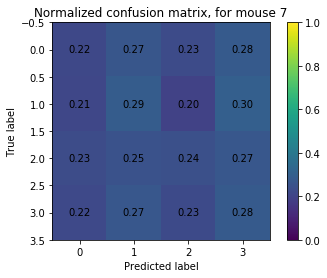

In [122]:
fold_avg = fold_cm[0]
for fold in range(1, len(fold_cm)):
    fold_avg += fold_cm[fold]
fold_avg = fold_avg/len(fold_cm)

cm_avg = fold_avg/np.sum(fold_avg, axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_avg)
plt.title('Normalized confusion matrix, for mouse {}'.format(expt_group['id']))


In [30]:
### Compare with sklearns direct computation. 

r0 = np.mean([x for x in roc_auc.values()])

from sklearn.metrics import roc_auc_score
r1 = roc_auc_score(y_true[dset], y_pred[dset], average='macro')

print(r0, r1)

0.9138256800153185 0.9138256800153185


Text(0.5,1,'Dataset 19')

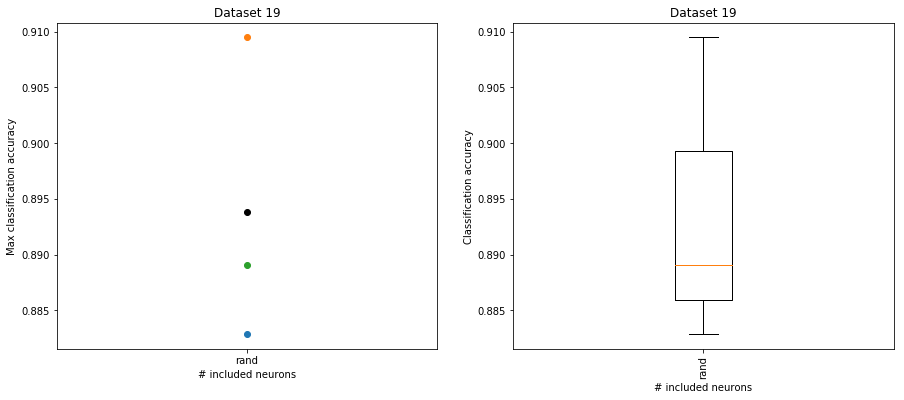

In [146]:
use_equal_spacing = False ### Plot x-axis with equal spacing (i.e. this is wrong for numneurons)

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
if use_equal_spacing:
    plt.plot([np.amax(accs_list[i]) for i in np.argsort(accs_names)], 'o')
    plt.xticks(np.arange(len(accs_names)), np.sort(accs_names), rotation='vertical')
    # plt.violinplot([accs_list[i] for i in np.argsort(accs_names)], np.arange(len(accs_names)))
else:
#     plt.plot(np.sort(accs_names), [np.amax(accs_list[i]) for i in np.argsort(accs_names)], 'o')
    plt.plot(np.sort(accs_names), [accs_list[i] for i in np.argsort(accs_names)], 'o')
    plt.plot(np.sort(accs_names), [np.mean(accs_list[i]) for i in np.argsort(accs_names)], 'ko')


plt.ylabel('Max classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(expt_group['id']))
plt.subplot(1,2,2)
plt.boxplot([accs_list[i] for i in np.argsort(accs_names)]) # Or violinplot
plt.xticks(np.arange(len(accs_names))+1, np.sort(accs_names), rotation='vertical')
plt.ylabel('Classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(expt_group['id']))

# LEGACY BELOW

In [5]:
data_opts = default_data_opts
data_opts['decoding_set'] = 1 # Choose ID of set of variables you are decoding. See code of get_data_for_decoding().
                              # 1: spout1/spout2/spout3/nolick; 2: lick/nolick
data_opts['bins_current'] = 0 # include frame of each event
data_opts['bins_before'] = 3 # frames before the event
data_opts['bins_after'] = 0 # frames after the event
data_opts['rand_seed'] = 1 # 0
data_opts['standardize_X'] = False
data_opts['train_feat'] = 'spikes'

data_split = get_data_for_decoding(CT, data_opts, do_debug=False)
print('X_train:', data_split['X_train'].shape, 'X_test:', data_split['X_test'].shape)

Data split into train, test, validate sets. 
Fractions: Train 0.504, Test 0.249 Valid 0.247
X_train: (29207, 3, 1401) X_test: (14449, 3, 1401)


/home/izkula/src/COSMOS/cosmos/traces/decoding_utils.py:919: RuntimeWarning: invalid value encountered in true_divide
  np.max(spout_lick_rates[1][trial]), 'co', label='spout 2')


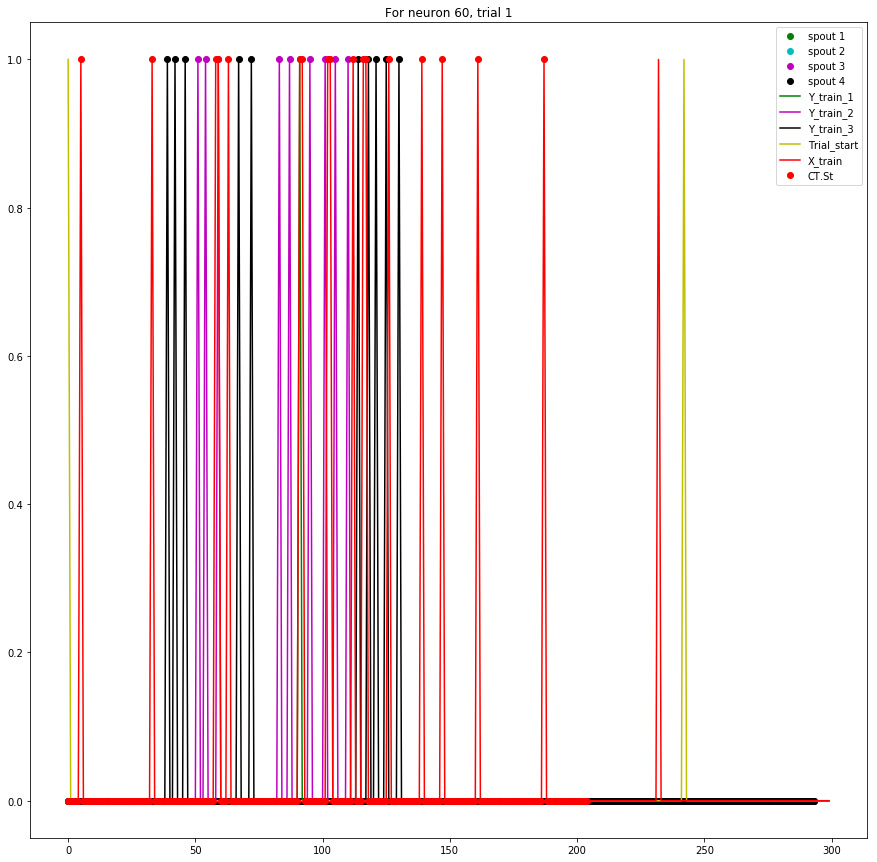

In [6]:
### Double check that licks are aligned correctly by plotting against
### direct-from-bpod lick rates. 
verify_data_alignment(trial_ind=1, which_cell=60, 
                      CT=CT, data_split=data_split, data_opts=data_opts)

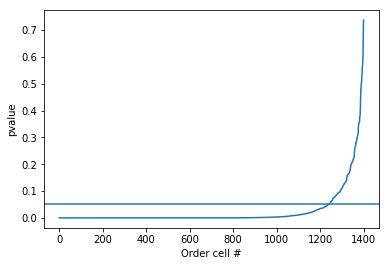

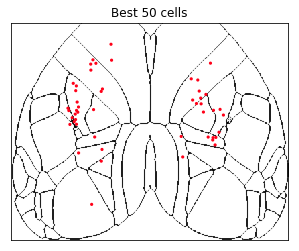

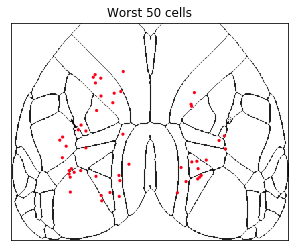

In [7]:
###  Rank the neural sources based on the ability 
###  of their activity to discriminate features of the licking/labels.
p_ordering = get_source_discriminativity(data_split, CT, data_opts, decoding_save_dir, do_plot=True)


# Train Dense neural net

In [180]:
### Remember to undo random seed at some point?

In [8]:
# Test what a single specified neuron_opts yields. 
doTest = False
if doTest:
    neuron_opts = {'nneurons': CT.ncells,
                   'neuron_set':'rand',
                   'neuron_rand_seed': 0,
                   'hemisphere':None,
                   'expt_num': get_last_expt_in_folder(decoding_save_dir) + 1}
    subsets = get_neurons_for_decoding(neuron_opts, CT, 1)
    neuron_opts['which_cells'] = subsets[0]  
    data_subset = set_neurons_for_decoding(data_split, neuron_opts, CT, do_plot=True)
    # ds = data_subset # The data actually used for training, and related info.

In [9]:
### Test what an experiment group looks like.
doTest = False
if doTest:
#     expt_param = {'expt_name': 'compare_subset_size', 
#                   'nrepeats': 2, 
#                   'neuron_rand_seed': 0}

#     expt_param = {'expt_name': 'compare_hemispheres', 
#                   'ordering': p_ordering, # Ordered subsets, by anova pvalue
#                   'neuron_rand_seed': 0,
#                   'nneurons': 400}
    
#     expt_param = {'expt_name': 'append_regions', 
#                   'ordering': None, # Will use every cell in the window, emanating from motor cortex.
#                   'neuron_rand_seed': 0}

    expt_param = {'expt_name':'unique_regions',
                  'ordering': p_ordering,
                  'neuron_rand_seed': 0,
                  'nneurons': 85}

    experiment_group = get_decoding_experiment_group(expt_param, CT, decoding_save_dir)

In [10]:
%pdb

Automatic pdb calling has been turned OFF


# experiments: 1
Expt range: 419 to 419
Expt 419, setting rand, nneurons 1401
EVR: 0.14766315037303815
---> Saved to: /home/izkula/Dropbox/cosmos_data/decoding_results/19/expt_000419


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


81.2300591468811
Total time: 81.23918


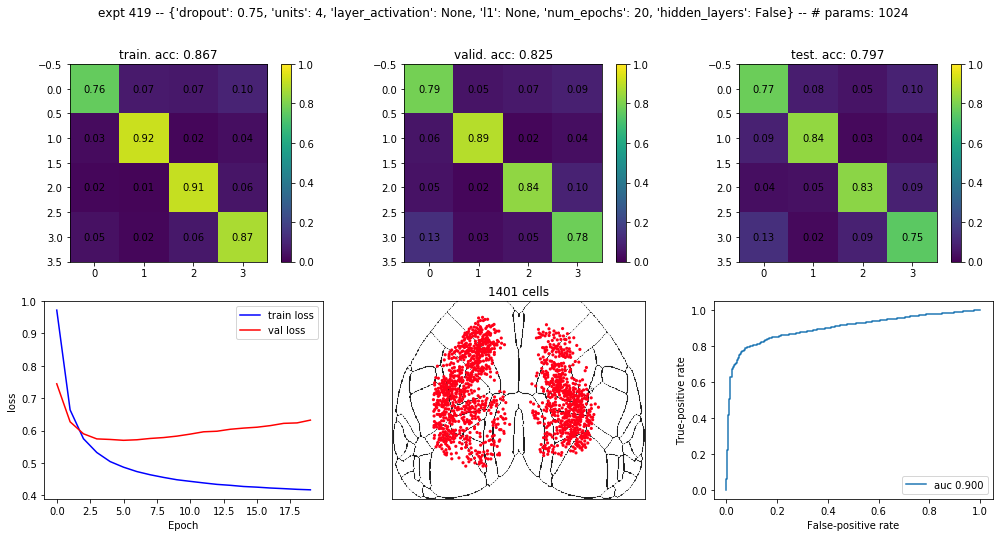

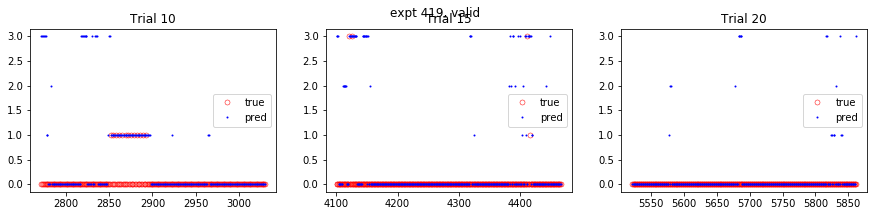

In [24]:
### Now, train the model!
### TODO: hyperparameter optimization
### TODO: Multiple runs per settings, with different random_seeds (i.e. different neurons).

t0 = time.time()

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

do_single_experiment = True
if do_single_experiment:
    ## If you want to do a single experiment.
    expt_param = None

    neuron_opts = {'nneurons': CT.ncells,
                   'neuron_set':'rand',
                   'neuron_rand_seed': 0,
                   'hemisphere':None,
                   'expt_num': get_last_expt_in_folder(decoding_save_dir) + 1
                  }
    subsets = get_neurons_for_decoding(neuron_opts, CT, nrepeats=1)
    neuron_opts['which_cells'] = subsets[0]         
    experiment_group = [neuron_opts]
else:
    expt_param = select_experiment_group(expt_group_id=9, ordering=p_ordering)
    experiment_group = get_decoding_experiment_group(expt_param, CT, decoding_save_dir)

print('# experiments: {}'.format(len(experiment_group)))
print('Expt range: {} to {}'.format(experiment_group[0]['expt_num'], experiment_group[-1]['expt_num']))
for neuron_opts in experiment_group:
    run_decoding_experiment(neuron_opts,
                            data_opts,
                            decoding_save_dir,
                            data_split,
                            CT,
                            dataset_id,
                            expt_param,
                            do_pca=True,
                            pca_components=85,
                            do_shuffle=False)
            
print('Total time: {:.5f}'.format(time.time() - t0))

In [ ]:
model.model.summary()

# Analyze results of training

In [147]:
concluded_expts = {
    0: {'id': 11, 'expt_nums': np.arange(178, 205), 'expt_type': 'neuron_set', 'info': '2way, 100 neurons' },
    1: {'id': 7,  'expt_nums': np.arange(1182, 1227), 'expt_type': 'neuron_set', 'info': '2way, 100 neurons'},
    2: {'id': 7,  'expt_nums': np.arange(1230, 1387), 'expt_type': 'neuron_set', 'info': '2way, 100 neurons'},
    
    ## Random subsets of different sizes
    3: {'id': 11, 'expt_nums': np.arange(207, 294), 'expt_type': 'nneurons', 'info': '4way'},
    4: {'id': 7,  'expt_nums': np.arange(1595, 1696), 'expt_type': 'nneurons', 'info': '4way'},
    5: {'id': 18, 'expt_nums': np.arange(5, 93), 'expt_type': 'nneurons', 'info':  '4way'},
    6: {'id': 19, 'expt_nums': np.arange(2, 117), 'expt_type': 'nneurons', 'info': '4way'},
    
    ## Random subsets from each region
    7: {'id': 11, 'expt_nums': np.arange(296, 334), 'expt_type': 'neuron_set', 'info': '4way'},
    8: {'id': 7,  'expt_nums': np.arange(1698, 1742), 'expt_type': 'neuron_set', 'info': '4way'},
    19:{'id': 19,  'expt_nums': np.arange(228, 279), 'expt_type': 'neuron_set', 'info': '4way'},
    20:{'id': 18, 'expt_nums': np.arange(137, 179), 'expt_type': 'neuron_set', 'info': '4way'},
    
    ## Random subsets from everywhere of different sizes, with 100 PCs
    9: {'id': 7, 'expt_nums': np.arange(1749, 1801), 'expt_type': 'nneurons', 'info': '4way, PCs'},
    10: {'id': 11, 'expt_nums': np.arange(341, 385), 'expt_type': 'nneurons', 'info': '4way, PCs'},
    11: {'id': 18, 'expt_nums': np.arange(93, 137), 'expt_type': 'nneurons', 'info': '4way, PCs'},
    12: {'id':19, 'expt_nums':np.arange(169, 226), 'expt_type':'nneurons', 'info':'4way, PCs'},
    13: {'id': 22, 'expt_nums':np.arange(1, 30), 'expt_type':'nneurons', 'info':'4way, PCs'},

    ## All neurons, for each dataset
    14: {'id': 22, 'expt_nums':np.array([32]), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    15: {'id': 7, 'expt_nums':np.array([1801]), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    16: {'id': 19, 'expt_nums':np.array([227]), 'expt_type':'nneurons', 'info':'4way, all neurons'}, # 79% acc!
    
    18: {'id': 7, 'expt_nums':np.array([1854]), 'expt_type':'nneurons', 'info':'4way, shuffled, all neurons'},

    # Subsets from everywhere, Now ordered by anova
#     21: {'id': 7, 'expt_nums':np.arange(1866, 1876), 'expt_type':'nneurons', 'info':'4way, all neurons'}, ### Wrong neuron numbers
#     22: {'id': 7, 'expt_nums':np.arange(1876, 1888), 'expt_type':'nneurons', 'info':'4way, PCA, all neurons'}, ### Wrong neuron numbers
    23: {'id': 11, 'expt_nums':np.arange(385, 397), 'expt_type':'nneurons', 'info':'4way, PCs'},
    24: {'id': 11, 'expt_nums':np.arange(397, 409), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    25: {'id': 18, 'expt_nums':np.arange(179, 191), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    26: {'id': 18, 'expt_nums':np.arange(191, 203), 'expt_type':'nneurons', 'info':'4way, PCs'},
    27: {'id': 19, 'expt_nums':np.arange(279, 291), 'expt_type':'nneurons', 'info':'4way, PCs'},
    28: {'id': 19, 'expt_nums':np.arange(291, 303), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    29: {'id': 7, 'expt_nums':np.arange(1888, 1900), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    30: {'id': 7, 'expt_nums':np.arange(1900, 1911), 'expt_type':'nneurons', 'info':'4way, PCs'},

    # Subsets from each region, ordered by anova
    31: {'id': 7, 'expt_nums':np.arange(1917, 1922), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    32: {'id': 11, 'expt_nums':np.arange(409, 414), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    33: {'id': 18, 'expt_nums':np.arange(203, 208), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    34: {'id': 19, 'expt_nums':np.arange(303, 308), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    
    # Subsets from each hemisphere, ordered by anova
    35: {'id': 19, 'expt_nums':np.arange(310, 312), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    36: {'id': 18, 'expt_nums':np.arange(208, 210), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    37: {'id': 7, 'expt_nums':np.arange(1922, 1924), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    38: {'id': 11, 'expt_nums':np.arange(414, 416), 'expt_type':'neuron_set', 'info':'4way, all neurons'},
    
    # Adding regions sequentially
#     39: {'id': 19, 'expt_nums':np.arange(313, 323), 'expt_type':'neuron_set', 'info':'4way, PCs'},
#     40: {'id': 7, 'expt_nums':np.arange(1925, 1935), 'expt_type':'neuron_set', 'info':'4way, PCs'},
#     41: {'id': 7, 'expt_nums':np.arange(1935, 1945), 'expt_type':'neuron_set', 'info':'4way, PCs'}, ### Tried with a hidden layer
#     42: {'id': 7, 'expt_nums':np.arange(1945, 1955), 'expt_type':'neuron_set', 'info':'4way, PCs'}, ### Seeing if the exact same result as 40
    43: {'id': 7, 'expt_nums':np.arange(1955, 1965), 'expt_type':'neuron_set', 'info':'4way, PCs'}, ### Swapping VIS and RSP order
    44: {'id': 11, 'expt_nums':np.arange(420, 430), 'expt_type':'neuron_set', 'info':'4way, PCs'}, 
    45: {'id': 18, 'expt_nums':np.arange(211, 221), 'expt_type':'neuron_set', 'info':'4way, PCs'}, 
    46: {'id': 19, 'expt_nums':np.arange(323, 333), 'expt_type':'neuron_set', 'info':'4way, PCs'}, 
    
    #### Rerunning everything with 85 PCs because one dataset only had 86 parietal sources.
    47: {'id': 11, 'expt_nums':np.arange(439, 444), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # regions
    48: {'id': 11, 'expt_nums':np.arange(445, 455), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'},  # cum regions
    49: {'id': 11, 'expt_nums':np.arange(467, 472), 'expt_type':'nneurons', 'info':'4way, 85 PCs'},  # nneurons
    
    50: {'id': 7, 'expt_nums':np.arange(1965, 1975), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'},  # cum regions
    51: {'id': 7, 'expt_nums':np.arange(1975, 1980), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'},  # regions
    52: {'id': 7, 'expt_nums':np.arange(1980, 1985), 'expt_type':'nneurons', 'info':'4way, 85 PCs'},  # nneurons
    
    53: {'id': 18, 'expt_nums':np.arange(221, 231), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'},  # cum regions
    54: {'id': 18, 'expt_nums':np.arange(231, 236), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'},  # regions
    55: {'id': 18, 'expt_nums':np.arange(236, 241), 'expt_type':'nneurons', 'info':'4way, 85 PCs'},  # nneurons

    56: {'id': 19, 'expt_nums':np.arange(343, 353), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'},  # cum regions
    57: {'id': 19, 'expt_nums':np.arange(338, 343), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'},  # regions
    58: {'id': 19, 'expt_nums':np.arange(333, 337), 'expt_type':'nneurons', 'info':'4way, 85 PCs'},  # nneurons
    
    62: {'id': 19, 'expt_nums':np.arange(402, 408), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 0
    63: {'id': 18, 'expt_nums':np.arange(241, 247), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 0
    64: {'id': 11, 'expt_nums':np.arange(472, 478), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 0
    65: {'id': 7, 'expt_nums':np.arange(1985, 1991), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 0

    66: {'id': 7, 'expt_nums':np.arange(1991, 1997), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 1
    67: {'id': 11, 'expt_nums':np.arange(478, 484), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 1
    68: {'id': 18, 'expt_nums':np.arange(247, 253), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 1
    69: {'id': 19, 'expt_nums':np.arange(408, 414), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 1

    70: {'id': 7, 'expt_nums':np.arange(1997, 2003), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 2
    71: {'id': 18, 'expt_nums':np.arange(253, 259), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 2
    72: {'id': 11, 'expt_nums':np.arange(484, 489), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 2
    73: {'id': 19, 'expt_nums':np.arange(396, 402), 'expt_type':'neuron_set', 'info':'4way, 85 PCs'}, # unique region contribution, not reducing num neurons for the all-regions comparison, randseed 2
}

In [151]:
expt_id = 71
expt_group = concluded_expts[expt_id]
decoding_load_dir = os.path.join(data_dir, 'decoding_results', str(expt_group['id']))
expt_nums = expt_group['expt_nums']
expt_type = expt_group['expt_type']
accs, expts_info = load_decoding_experiments(decoding_load_dir, expt_nums)
accs_list, accs_names, expt_nums_organized = organize_decoding_experiments(accs, expts_info, expt_type) #'nneurons', 'neuron_set', 'hemisphere'
# get_included_neuron_coverage(expts_info, param)
accs_names

array(['~M', '~S', '~V', '~R', '~n', '~P'], dtype='<U2')

Text(0.5,1,'Dataset 19')

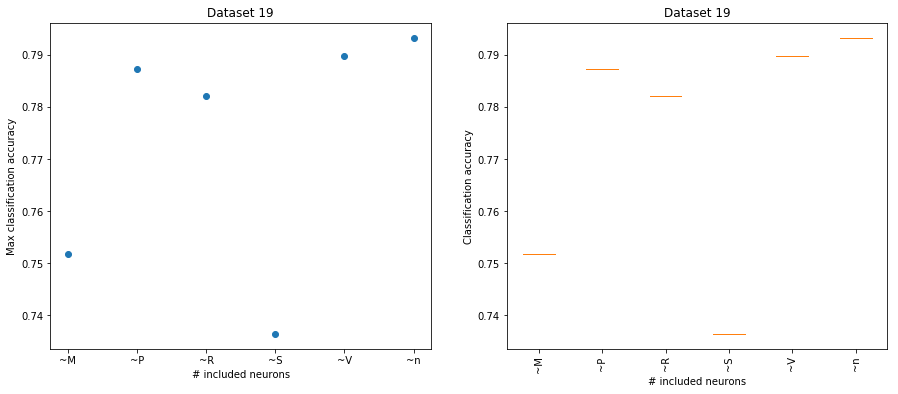

In [153]:
use_equal_spacing = False ### Plot x-axis with equal spacing (i.e. this is wrong for numneurons)

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
if use_equal_spacing:
    plt.plot([np.amax(accs_list[i]) for i in np.argsort(accs_names)], 'o')
    plt.xticks(np.arange(len(accs_names)), np.sort(accs_names), rotation='vertical')
    # plt.violinplot([accs_list[i] for i in np.argsort(accs_names)], np.arange(len(accs_names)))
else:
#     plt.plot(np.sort(accs_names), [np.amax(accs_list[i]) for i in np.argsort(accs_names)], 'o')
    plt.plot(np.sort(accs_names), [accs_list[i] for i in np.argsort(accs_names)], 'o')


plt.ylabel('Max classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(expt_group['id']))
plt.subplot(1,2,2)
plt.boxplot([accs_list[i] for i in np.argsort(accs_names)]) # Or violinplot
plt.xticks(np.arange(len(accs_names))+1, np.sort(accs_names), rotation='vertical')
plt.ylabel('Classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(expt_group['id']))

# CLASSIFICATION SUMMARY ACROSS MICE

In [ ]:
# Setup datasets and experiments
# data_info = { # This is for: data_opts['decoding_set'] = 1 (4 way classify)
#              [7, np.arange(1595, 1696)],
#              [11, np.arange(207, 294)],
#              [18, np.arange(5, 92)],
#              [19, np.arange(2, 117)]
# }

expt_group_ids = [3, 4, 5, 6]  # This is for: data_opts['decoding_set'] = 1 (4 way classify)

In [ ]:
# Plot summary across mice (mice across days to increase n?)

In [ ]:
# Plot example decoding for each dataset that yielded the max accuracy of that group

# Below: If you want to load a single experiment

In [ ]:
load_dataset_id = 19
decoding_load_dir = os.path.join(data_dir, 'decoding_results', str(load_dataset_id))

plot_dir_loaded = os.path.join(decoding_load_dir, 'plots')
if not os.path.exists(plot_dir_loaded):
    os.makedirs(plot_dir_loaded)

dataset = params.DATASETS[load_dataset_id]
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = fig_save_dir
dataset['behavior_dir'] = bpod_dir
CT_load = CosmosTraces(dataset)
BD = CT_load.bd

In [ ]:
expt_num= 117
expt_file = os.path.join(decoding_load_dir, 'expt_{:06}'.format(expt_num))


do_load = True
if do_load:
    model = keras.models.load_model(expt_file + '_model')
    with open(expt_file + '_history', "rb") as handle:
        history = pickle.load(handle)
#     with open(expt_file + '_ds', "rb") as handle:
#         ds = pickle.load(handle)
#         sample_weights = ds['sample_weights']
    with open(expt_file + '_opts', "rb") as handle:
        opts = pickle.load(handle)
#     with open(expt_file + '_decode_summary', "wb") as handle:
#         pickle.dump(decode_summary, handle)
        
    # Regenerate data subsets.
    data_split = get_data_for_decoding(CT_load, opts['data_opts'], do_debug=False)
    ds = set_neurons_for_decoding(data_split, opts['neuron_opts'], CT_load, do_plot=True)
    sample_weights = get_sample_weights(ds, ['train', 'valid', 'test'])
else:
    # Note: This will not use the best model, only the most recent.
    model = model_dnn.model
    history = train_hist.history
    ds = ds
    
decode_summary = summarize_decoding_results(ds, model, history, sample_weights)


In [ ]:
plot_decoding_summary(expt_num, opts['train_opts'], decode_summary, 
                      CT_load, opts['neuron_opts'], ds, history,
                     model.model.count_params())
plt.savefig(plot_dir_loaded + '/summary_' + 'expt_{:06}'.format(expt_num) + '.png')


In [ ]:
trials = [10, 15, 20]
plot_decoded_trials(trials, ds, decode_summary, expt_num, subset='valid')
plt.savefig(plot_dir_loaded + '/trials_' + 'expt_{:06}'.format(expt_num) + '.png')


# DELETE ALL BELOW THIS?

In [ ]:
###TODO TODO TODO. Is this irrelevent? Each neuron should be included anyways. 
# def get_included_neuron_coverage(expts_info, param):
#     """
#     For each value of 'param', indicate which neurons were
#     included in the set of decoding experiments with that value.
    
#     I.e. for all of the experiments with 'nneurons' = 20,
#     which neurons were included for decoding, across all of
#     the experiments. 
    
#     :param expts_info: dict containing info about each experiment, 
#                        corresponds to accs.
#     :param param: key into expts_info to use for grouping experiments.
    
#     :return which_cells_list: list of np.arrays. Each array contains the
#                               indices of the neurons that have been
#                               tested with the corresponding value of param. 
#     :return which_cells_organized: dict
    
#     :return coverage: dict. for each value of param, the coverage. 
#     """
    
#     accs_organized = defaultdict(list)
#     which_cells_organized = defaultdict(list)
#     setting = np.unique(expts_info[param])
    
#     for i in range(len(setting)):
#             accs_organized[str(setting[i])].append(accs[data_subset][i])
#             which_cells_organized[str(setting[i])].extend(which_cells[i])

#     accs_list = [np.array(val) for key, val in accs_organized.items()]
#     accs_names = [key for key, val in accs_organized.items()]
#     which_cells_list = [which_cells_organized[x] 
#                         for x in which_cells_organized.keys()]

#     accs_names = np.array(accs_names)
#     if param == 'nneurons':
#         accs_names = accs_names.astype(int)
    
#     return which_cells_organized, coverage

### Below is legacy pre-factored code. 

In [ ]:
accs_names

In [ ]:
### Compare accuracy of a bunch of runs
# expt_nums = range(103, 203)
expt_nums = np.concatenate([np.arange(104, 199), np.arange(216, 295), np.arange(299, 428), np.arange(440, 499),
                            np.arange(504, 653)]) # Total numbers 'rand' comparison
expt_nums = np.concatenate([np.arange(657, 707)]) # Region comparison
expt_nums = np.concatenate([np.arange(711, 761)]) # Region comparison with 20 epochs
expt_nums = np.concatenate([np.arange(762, 772)])
expt_nums = np.concatenate([np.arange(711, 761), np.arange(775, 874)]) # Pairs and single regions
expt_nums = np.concatenate([np.arange(876, 975)]) # 200 cells per region (for those that can)
expt_nums = np.concatenate([np.arange(979, 1181)])
accs = defaultdict(list)
neuron_sets = []
neuron_rand_seeds = []

nneurons = []
which_cells = []

for expt_num in expt_nums:
    if expt_num < 200:
        expt_file = os.path.join(decoding_save_dir, 'expt_{:04}'.format(expt_num))
    else:
        expt_file = os.path.join(decoding_save_dir, 'expt_{:06}'.format(expt_num))

    with open(expt_file + '_opts', "rb") as handle:
            opts = pickle.load(handle)
    with open(expt_file + '_decode_summary', "rb") as handle:
            decode_summary = pickle.load(handle)

    for dset in ['train', 'valid', 'test']:
        accs[dset].append(np.mean(np.diag(decode_summary['confusion'][dset])))
            
    neuron_sets.append(opts['neuron_opts']['neuron_set'])
    neuron_rand_seeds.append(opts['neuron_opts']['neuron_rand_seed'])
    nneurons.append(opts['neuron_opts']['nneurons'])
    which_cells.append(opts['neuron_opts']['which_cells'])
    
## Now organize them according to what you are trying to plot
accs_organized = defaultdict(list)
which_cells_organized = defaultdict(list)
setting = nneurons
# setting=neuron_sets
for i in range(len(setting)):
        accs_organized[str(setting[i])].append(accs['test'][i])
        which_cells_organized[str(setting[i])].extend(which_cells[i])

accs_list = [np.array(val) for key, val in accs_organized.items()]
accs_names = [key for key, val in accs_organized.items()]

In [ ]:
[print(x, len(np.unique(which_cells_organized[x]))) for x in which_cells_organized.keys()]

In [ ]:
np.array(accs_names).astype(int)

In [ ]:
## Plot accuracy vs. neuron_set
accs_names = np.array(accs_names).astype(int)
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.violinplot([accs_list[i] for i in np.argsort(accs_names)], np.arange(len(accs_names)))
plt.ylabel('Classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(dataset_id))
plt.xticks(np.arange(len(accs_names)), np.sort(accs_names), rotation='vertical')
plt.subplot(1,2,2)
plt.boxplot([accs_list[i] for i in np.argsort(accs_names)])
plt.xticks(np.arange(len(accs_names))+1, np.sort(accs_names), rotation='vertical')
plt.ylabel('Classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(dataset_id))

In [ ]:
## Plot accuracy vs. number of included neurons
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.violinplot([accs_list[i] for i in np.argsort(accs_names)], np.arange(len(accs_names)))
plt.ylabel('Classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(dataset_id))
plt.xticks(np.arange(len(accs_names)), np.sort(accs_names))
plt.subplot(1,2,2)
plt.boxplot([accs_list[i] for i in np.argsort(accs_names)])
plt.xticks(np.arange(len(accs_names))+1, np.sort(accs_names))
plt.ylabel('Classification accuracy')
plt.xlabel('# included neurons')
plt.title('Dataset {}'.format(dataset_id))

In [ ]:
## Plot coverage of all of the training runs within a subset
plt.figure()
coverage = np.array([len(np.unique(which_cells_organized[x])) for x in accs_names])
plt.plot(np.arange(len(accs_names)), coverage[np.argsort(accs_names)]/CT.ncells, 'o')
plt.xticks(np.arange(len(accs_names)), np.sort(accs_names))
plt.ylim([0, 1.1])
plt.ylabel('Fraction of total cells')
plt.title('Coverage across all subsets of neurons')
plt.xlabel('Subset size')

for ncells in np.sort(accs_names):
    plt.figure()
    
    CT.centroids_on_atlas(np.ones(np.unique(which_cells_organized[ncells]).shape), 
                      np.unique(which_cells_organized[ncells]), max_radius=10)
    plt.title('Set size {}, coverage {} '.format(ncells, 
                                                 int(len(np.unique(which_cells_organized[ncells])))/CT.ncells))



In [ ]:
plt.plot(accs_names, coverage, 'o')

In [ ]:
accs_names, coverage

In [ ]:
# Set class weights for training
# Y_classes = np.argmax(data_split['Y_train'],1)

# weights = compute_class_weight('balanced',
#                                np.unique(Y_classes),
#                                Y_classes)

# class_weight = dict(zip(np.unique(Y_classes).astype(np.int), weights))

In [ ]:
### Goal #1: Make a plot, with error bars, of test accuracy vs. 
### different numbers of neurons (but use different subsets) across the whole

In [ ]:
### Goal #2: Make a plot, with error bars, of test accuracy vs. 
### different regions, as well as different combinations of regions.

In [ ]:
### Goal #3: Is it specific neurons that are necessary? 
# You could really try this analysis in a fine grained manner...